## Important Note

To make use of the **Adaptation Measure** class, you must check out the branch  
`feature/cb_refactoring`.

---

## Setup Instructions

The simplest way to enable the features is the following:

```bash
# Create environment with Python 3.11
mamba create -n <envname> "python==3.11.*"

# Fetch and checkout the feature branch
git fetch
git checkout feature/cb_refactoring

# Update environment with requirements
mamba env update -n <envname> -f requirements/env_climada.yml

# Activate environment
mamba activate <envname>

# Install the package in editable mode
python -m pip install -e ./


# 🌳 Cost–Benefit Analysis of Canopy Compositions

---

## 🎯 Objective  
This notebook estimates the **current and future yields and revenues** of coffee, cacao, and banana systems under different **agroforestry canopy compositions**.  

We focus on two key climate hazards:  
- 🌡️ **Heat stress** – represented by maximum daily temperatures.  
- 💨 **Drought stress** – represented by vapor pressure deficit (VPD).  

The aim is to compare the **costs and benefits** of modifying shade—or even switching the main crop—under climate risk conditions.  
In line with the **BioFinCas** project vision, this notebook demonstrates how **CLIMADA** can model *ecosystem services*, here defined as the regulation of climate hazards through canopy composition, by linking **exposure × hazard × vulnerability**.

---

## 🌱 Agroforestry as an Ecosystem Service  
Agroforestry systems provide multiple ecosystem services:  
- 🌍 soil fertility & nutrient cycling  
- 🐝 pollination & pest control  
- 🌧️ water regulation & erosion prevention  
- 🌳 **microclimate regulation (shade, cooling, humidity)**  

👉 For tractability, we focus on the **cooling & drought-buffering effects of canopy shade** as the main service influencing hazard intensity.  

Yields are adjusted with an **empirical canopy–yield function** (Contreras Fleury, 2025), reflecting how shade modifies crop productivity. While simplified, this approach makes it possible to integrate ecosystem services into risk modeling in a transparent way.  

---

## 🔬 Approach  
We combine:  
- 🌿 **Canopy composition scenarios** – present vs. alternative systems  
- 📈 **Canopy–yield functions** – empirical evidence on shade–yield trade-offs (optimal ~30–60% shade)  
- 🛡️ **CLIMADA hazard modeling** – adjusting both **exposure values** (crop revenues) and **impact functions** (damage curves)  
- 📊 **Risk metrics** – Annual Average Loss (AAL) and bad-year losses for present & future climates  
- 💰 **Cost–benefit analysis** – integrating costs (planting, maintenance) with hazard-adjusted revenues into **Net Present Value (NPV)**  

This framework helps test whether canopy diversification is **economically advantageous** when accounting for:  
- ⚖️ Production trade-offs (yield gains/losses from shade–yield dynamics)  
- 🛡️ Risk reduction benefits (avoided damages from shade cooling & drought buffering)  

---

## 🗂️ Notebook Workflow  

The notebook is structured into the following steps:

0. ⚙️ **Initial Parameters**  
   Define global settings, constants, and parameters used throughout the analysis.  

1. 🌳 **Load and Prepare Canopy & Crop Data**  
   Import datasets and organize canopy compositions for present vs. alternative scenarios.  

2. 💵 **Exposure**  
   Build CLIMADA exposure objects, adjusting baseline crop values to reflect canopy–yield effects.  

3. 🌡️ **Hazard**  
   Load hazard datasets (Tmax or VPD) for present and future climate scenarios.  

4. 🛡️ **Impact Function (Vulnerability)**  
   Adjust and apply damage functions that reflect how shade modifies vulnerability to hazards.  

5. 📈 **Cost**  
   Define crop costs and under different canopy setups and account for direct cost structures.  

6. 💰 **Discount Rates**  
   Define financial discounting for long-term cost–benefit analysis (Net Present Value).  

7. 🧮 **Measures**  
   Define adaptation measures, based on the canopy and crop compostion for each alternative.  

8. 🔄 **Cost & Revenue Estimates**  
   Integrate canopy-adjusted revenues, costs, and climate risk into comparative tables and averages.  

9. 📎 **Extra Material**  
   Additional data, notes, or exploratory outputs used to support the main analysis.  

---

✨ Together, these steps demonstrate how **canopy composition** affects both  
- ⚖️ **economic outcomes** (costs, revenues, NPV)  
- 🛡️ **risk outcomes** (hazard exposure, vulnerability, avoided losses).  


---

✨ This notebook bridges **biodiversity-friendly agroforestry practices** with **quantitative climate risk modeling**, showing how canopy design can shape both **farmer incomes** and **ecosystem resilience**.  


# 0 – Initial parameters

Below are some inital helpful parameters to help the analysis further on using the deafult settings

In [1]:
from pathlib import Path
import os
from utils_CB import BASE_DIR, INPUT_DIR, OUTPUT_DIR

# Define the folder where you stored the downloaded TerraClim data
TERRACLIMATE_DIR = Path("/Users/viggo/Documents/Programming/Consult/UNU/data")

# Define the hazard type 
hazard_type = 'VPD' # 'Tmax' for temperature, 'VPD' for vapor pressure deficit

# Define the future scenario
future_climate_scenario = 'plus2C' # 'plus2C' or 'plus4C'

## 0.1 – Decide on the pre-generated agroforesty system to analyze 

In [2]:
from pathlib import Path

# Help list to locate the excel files for different compositions
compositions = [
    "20250819__Cacao__AltaVerapaz",
    "20250819__Cacao__DR_Cibao_Noroeste",
    "20250819__Coffee__DR_Cibao_Noroeste",
    "20250819__Coffee__Veracruz",
    "20250819__Coffee__WesternHighlands"
]

# Decide which composition to use (0 to 4)
agroforestry_system = compositions[1]  # Extract the crop name from the first composition

# Load the excel file for a specific composition
excel_file = BASE_DIR.parent / f"agroforestry_systems/{agroforestry_system}.xlsx"
print(excel_file)

/Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/agroforestry_systems/20250819__Cacao__DR_Cibao_Noroeste.xlsx


Create the format incluing the prices and costs

In [3]:
from utils_CB import write_adjusted

# Create the excel sheet with adjusted values
file_name = write_adjusted(excel_file)

Using input excel file: /Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/agroforestry_systems/20250819__Cacao__DR_Cibao_Noroeste.xlsx
Loaded sheet: present with 70 rows.
+----+---------------------+----------+------------------+---------------------------+--------------------+-------------+---------------------+------------------------+------------+-------------+----------------+-----------+
|    | Region              | System   |   Plot size (ha) | Species                   | Scientific name    |   Plants/ha |   Yield (t/ha/year) |   Per-tree shading (%) |   Latitude |   Longitude |   Altitude (m) |   Plot ID |
|----+---------------------+----------+------------------+---------------------------+--------------------+-------------+---------------------+------------------------+------------+-------------+----------------+-----------|
|  0 | DR - Cibao Noroeste | Cacao    |                1 | Cacao (main crop)         | Theobroma cacao    |         nan |             

Add prices and adjust canopy for consitency

In [4]:
# # %% [markdown]
# # # Compare the composition files

# # %% [markdown]
# # Define the excel_file name

# # %%  
    
# from matplotlib.pylab import f


# def write_adjusted(OUTPUT_DIR = OUTPUT_DIR, excel_file = excel_file):

#     # %% [markdown]
#     excel_file = Path(excel_file)
#     print(f"Using input excel file: {excel_file}")
#     agroforestry_system = excel_file.stem

#     from tabulate import tabulate

#     # Define output and input directories
#     #INPUT_DIR_VICTOR = Path("/Users/viggo/Documents/Programming/Consult/UNU/data")
#     # Make a directory for the modified agroforestry systems in agroforestry_system
#     OUTPUT_DIR = OUTPUT_DIR / agroforestry_system
#     OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


#     #file_name_Victor = "canopy_crop_composition.xlsx"


#     # %% [markdown]
#     # Read Victors excel_file

#     # %%
#     # import pandas as pd
#     # from tabulate import tabulate

#     # # get the number of sheets in the Excel excel_file apart from the 'Current' sheet
#     # excel_file = INPUT_DIR_VICTOR / file_name_Victor
#     # canopy_comps = pd.ExcelFile(excel_file).sheet_names

#     # # Create a dictionary to hold the canopy composition data
#     # canopy_crop_victor_dict = {}
#     # for sheet in canopy_comps:
#     #     canopy_crop_victor_dict[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
#     #     print(f"Loaded sheet: {sheet} with {len(canopy_crop_victor_dict[sheet])} rows.")
#     #     print(tabulate(canopy_crop_victor_dict[sheet].head(), headers='keys', tablefmt='psql'))

#     # %% [markdown]
#     # Zélies files

#     # %%
#     import pandas as pd

#     # get the number of sheets in the Excel excel_file apart from the 'Current' sheet
#     canopy_comps_zelie = pd.ExcelFile(excel_file).sheet_names

#     # Modify the DataFrame to get the site_id and rename columns
#     def modify_canopy_crop_df(df: pd.DataFrame) -> pd.DataFrame:
#         df = df.copy()
        
#         # Generate unique site_id
#         df["Plot ID"] = df.groupby(["Latitude", "Longitude"]).ngroup()

#         # Chnage ti string
#         df["Plot ID"] = df["Plot ID"].astype(str)

#         return df

#     # Create a dictionary to hold the canopy composition data
#     canopy_crop_zelie_dict = {}
#     for sheet in canopy_comps_zelie:
#         canopy_crop_zelie_dict[sheet] = pd.read_excel(excel_file, sheet_name=sheet)
#         canopy_crop_zelie_dict[sheet] = modify_canopy_crop_df(canopy_crop_zelie_dict[sheet])
#         print(f"Loaded sheet: {sheet} with {len(canopy_crop_zelie_dict[sheet])} rows.")
#         print(tabulate(canopy_crop_zelie_dict[sheet], headers='keys', tablefmt='psql'))

#     # %% [markdown]
#     # ## Compare the two 'present' composition

#     # %%
#     # # Print only the first item
#     # print(f"Zélies files: \n{tabulate(canopy_crop_zelie_dict['present'], headers='keys', tablefmt='psql')}")
#     # print(f"Victors files:\n{tabulate(canopy_crop_victor_dict['present'], headers='keys', tablefmt='psql')}")

#     # # Print the columns missing in Zélies
#     # zelie_columns = set(canopy_crop_zelie_dict['present'].columns)
#     # victor_columns = set(canopy_crop_victor_dict['present'].columns)

#     # missing_in_zelie = victor_columns - zelie_columns
#     # missing_in_victor = zelie_columns - victor_columns

#     # print(f"Columns missing in Zélies: {missing_in_zelie}")
#     # print(f"Columns missing in Victor: {missing_in_victor}")

#     # %% [markdown]
#     # # Get all the unique Species and Species Names acrross the sheets

#     # %%
#     for sheet in canopy_crop_zelie_dict:
#         print(f"Sheet: {sheet}")
#         print(tabulate(canopy_crop_zelie_dict[sheet].head(), headers='keys', tablefmt='psql'))

#     # %%
#     import copy
#     import pandas as pd

#     # Copy the Zélie present DataFrame to adjust it
#     canopy_crop_zelie_dict_adjusted = copy.deepcopy(canopy_crop_zelie_dict)

#     # %% [markdown]
#     # Generate unique Site ID

#     # %%
#     # Generate unique site_id
#     for sheet, df in canopy_crop_zelie_dict_adjusted.items():
#         df["site_id"] = df.groupby(["Latitude", "Longitude"]).ngroup()

#     # %% [markdown]
#     # Define the default values

#     # %%
#     # Set estimates (USD per tonne)
#     DR_TYPICAL_PRICE_TONNE_USD = {
#         "Coffee": 2580,  # 20% premium for specialty coffee
#         "Cacao":  3760,   # ≈ matches coffee’s $/ha at 0.5 t/ha
#         "Banana": 330,
#     }

#     DR_TYPICAL_YIELD = { # tonnes per hectare per year
#         "Coffee": 0.73,
#         "Cacao":  0.50,
#         "Banana": 22.64,
#     }

#     DR_TYPICAL_PLANTS_PER_HA = { # plants per hectare
#         "Coffee": 3000,
#         "Cacao":  1000,
#         "Banana": 2000,
#     }

#     # %% [markdown]
#     # ## Add Plants/ha for teh main crops coffe, cacao and banana to each sheet

#     # %%
#     import pandas as pd
#     import numpy as np


#     # species we care about Scientific names, species names
#     TARGETS = {
#         "Coffea arabica":   ("Coffee (main crop)", "Coffee"),
#         "Theobroma cacao":  ("Cacao (main crop)",  "Cacao"),
#         "Musa spp.":        ("Banana",             "Banana"),
#     }

#     def ensure_main_species_and_update_plants(df: pd.DataFrame) -> pd.DataFrame:
#         out = df.copy()

#         # ensure numeric for checks
#         out["Yield (t/ha/year)"] = pd.to_numeric(out["Yield (t/ha/year)"], errors="coerce")
#         out["Plants/ha"] = pd.to_numeric(out["Plants/ha"], errors="coerce")

#         rows_to_add = []

#         # group by Plot ID + Region as requested
#         for (plot_id, region), g in out.groupby(["Plot ID", "Region"], dropna=False):
#             base = g.iloc[0].to_dict()  # copy plot metadata

#             for sci_name, (common_label, key) in TARGETS.items():
#                 present = g[g["Scientific name"] == sci_name]

#                 if not present.empty:
#                     # update Plants/ha only where yield is known
#                     idx = present.index[present["Yield (t/ha/year)"].notna()]
#                     if len(idx):
#                         out.loc[idx, "Plants/ha"] = DR_TYPICAL_PLANTS_PER_HA[key]
#                 else:
#                     # add a new row for this plot with Plants/ha = 0
#                     new_row = {col: base.get(col, np.nan) for col in out.columns}
#                     new_row["Scientific name"] = sci_name
#                     if "Species" in new_row:
#                         new_row["Species"] = common_label
#                     if "Plants/ha" in new_row:
#                         new_row["Plants/ha"] = 0
#                     if "Yield (t/ha/year)" in new_row:
#                         new_row["Yield (t/ha/year)"] = np.nan
#                     rows_to_add.append(new_row)

#         if rows_to_add:
#             out = pd.concat([out, pd.DataFrame(rows_to_add)], ignore_index=True)

#         # Sort the DataFrame by Plot ID and Region
#         out.sort_values(by=["Plot ID", "Region", "Scientific name"], inplace=True)

#         return out

#     # Do it for all sheets in the Zélie dictionary
#     for sheet, df in canopy_crop_zelie_dict_adjusted.items():
#         canopy_crop_zelie_dict_adjusted[sheet] = ensure_main_species_and_update_plants(df)
#         # Print the adjusted DataFrame for the sheet
#         print(f"Adjusted Zélie DataFrame for sheet '{sheet}':\n{tabulate(canopy_crop_zelie_dict_adjusted[sheet], headers='keys', tablefmt='psql')}")
#         print(f"Adjusted Zélie DataFrame for sheet '{sheet}' has {len(canopy_crop_zelie_dict_adjusted[sheet])} rows.")


#     # %% [markdown]
#     # ## Get the unique species, scientific names and shade levels across all alternatives 

#     # %%


#     # For all sheets except 'present', only store the columns
#     unique_cols = ["site_id", "Species", "Scientific name", "Per-tree shading (%)"]

#     # 1) Stack all sheets, tagging each row with its sheet idx
#     stacked = pd.concat(
#         [df[unique_cols].assign(Source=idx)
#         for idx, (_, df) in enumerate(canopy_crop_zelie_dict_adjusted.items())],
#         ignore_index=True
#     )

#     # 2) Prefer rows that HAVE shade; within those, prefer the smallest sheet idx
#     stacked["_shade_missing"] = stacked["Per-tree shading (%)"].isna()
#     stacked = stacked.sort_values(
#         ["site_id", "Species", "Scientific name", "_shade_missing", "Source"],
#         ascending=[True, True, True, True, True]   # non-NaN first (False < True), then lowest idx
#     )

#     # 3) Keep the first occurrence per (site_id, Species, Scientific name)
#     df_unique_species = (
#         stacked
#         .drop_duplicates(subset=["site_id", "Species", "Scientific name"], keep="first")
#         .drop(columns=["_shade_missing"])
#         .reset_index(drop=True)
#     )[["site_id", "Species", "Scientific name", "Per-tree shading (%)", "Source"]]

#     # If you want to see it:
#     # from tabulate import tabulate
#     print(tabulate(df_unique_species, headers='keys', tablefmt='psql'))

#     # Drop the 'Source' column if not needed
#     df_unique_species = df_unique_species.drop(columns=["Source"])
#     print(f"Unique species DataFrame has {len(df_unique_species)} rows.")

#     # %% [markdown]
#     # Adjust so the other sheets only have limited columns

#     # %%
#     import copy

#     # For all sheets except 'present', only store the columns 
#     store_columns = ["Plot ID", "Latitude", "Longitude", "Region", "System", "Plot size (ha)", "Species", "Scientific name", "Plants/ha"]
#     for sheet in canopy_crop_zelie_dict_adjusted:
#         if sheet != "present":
#             canopy_crop_zelie_dict_adjusted[sheet] = canopy_crop_zelie_dict_adjusted[sheet][store_columns]

#     # For each sheet in the Zélies data, add the region key
#     for sheet in canopy_crop_zelie_dict_adjusted:
#         canopy_crop_zelie_dict_adjusted[sheet]["Region_key"] = canopy_crop_zelie_dict_adjusted[sheet]["Region"].str.split(" - ", n=1).str[0].str.strip()


#     # %%
#     for sheet, df in canopy_crop_zelie_dict_adjusted.items():
#         print(f"Sheet: {sheet}")
#         print(tabulate(df, headers='keys', tablefmt='psql'))

#     # %% [markdown]
#     # Adjust the 'present' sheet so to have a specific Species                   | Scientific name    |   Per-tree shading (%) taken from the other sheets 

#     # %%
#     import pandas as pd
#     import numpy as np

#     import pandas as pd
#     import numpy as np

#     def backfill_species_any_sheet(
#         sheet_df: pd.DataFrame,
#         df_unique_species: pd.DataFrame,
#         present_df_for_site_map: pd.DataFrame
#     ) -> pd.DataFrame:
#         """
#         Ensure each site (by site_id) in `sheet_df` contains all (Species, Scientific name)
#         pairs from `df_unique_species` for that site. Append missing rows with Plants/ha = 0.
#         If 'Per-tree shading (%)' exists in sheet_df, copy it from df_unique_species.

#         site_id mapping:
#         1) by exact 'Plot ID' to present
#         2) if still missing, by numeric suffix of Plot ID (e.g., 001, 002, 003)
#         """
#         out = sheet_df.copy()

#         needed_min = {"Plot ID", "Region", "System", "Species", "Scientific name", "Plants/ha"}
#         missing = needed_min - set(out.columns)
#         if missing:
#             raise ValueError(f"Sheet is missing required columns: {missing}")

#         out["Plants/ha"] = pd.to_numeric(out["Plants/ha"], errors="coerce")

#         need_unique = {"site_id","Species","Scientific name","Per-tree shading (%)"}
#         if not need_unique.issubset(df_unique_species.columns):
#             raise ValueError("df_unique_species must have: site_id, Species, Scientific name, Per-tree shading (%)")

#         # --- build site_id map from present ---
#         pres = present_df_for_site_map[["Plot ID","site_id"]].drop_duplicates().copy()
#         pres["_suffix"] = pres["Plot ID"].str.extract(r"(\d+)$", expand=False)

#         added_temp_site = False
#         if "site_id" not in out.columns:
#             out = out.merge(pres[["Plot ID","site_id"]], on="Plot ID", how="left")
#             added_temp_site = True

#         # if still missing site_id, map by numeric suffix
#         if out["site_id"].isna().any():
#             out["_suffix"] = out["Plot ID"].str.extract(r"(\d+)$", expand=False)
#             out = out.merge(
#                 pres[["_suffix","site_id"]].rename(columns={"site_id":"site_id_by_suffix"}),
#                 on="_suffix",
#                 how="left"
#             )
#             out["site_id"] = out["site_id"].fillna(out["site_id_by_suffix"])
#             out = out.drop(columns=[c for c in ["_suffix","site_id_by_suffix"] if c in out.columns])

#         # If we still have no site_id for a row, we can’t backfill it
#         existing = set(zip(out["site_id"], out["Species"], out["Scientific name"]))

#         new_rows = []
#         for sid, grp in df_unique_species.groupby("site_id", dropna=False):
#             if pd.isna(sid):
#                 continue
#             base_rows = out[out["site_id"] == sid]
#             if base_rows.empty:
#                 continue

#             base = base_rows.iloc[0].to_dict()
#             for _, r in grp.iterrows():
#                 key = (sid, r["Species"], r["Scientific name"])
#                 if key in existing:
#                     continue

#                 new_row = {col: base.get(col, np.nan) for col in out.columns}
#                 new_row["site_id"] = sid
#                 new_row["Species"] = r["Species"]
#                 new_row["Scientific name"] = r["Scientific name"]
#                 new_row["Plants/ha"] = 0
#                 if "Per-tree shading (%)" in out.columns:
#                     new_row["Per-tree shading (%)"] = r["Per-tree shading (%)"]
#                 new_rows.append(new_row)

#         if new_rows:
#             out = pd.concat([out, pd.DataFrame(new_rows)], ignore_index=True)

#         if added_temp_site:
#             out = out.drop(columns=["site_id"])

#         sort_cols = [c for c in ["Plot ID","site_id","Species","Scientific name"] if c in out.columns]
#         return out.sort_values(sort_cols).reset_index(drop=True)


#     # Keep 'present' with full columns (including site_id) so we can map site_id by Plot ID.
#     present_full = canopy_crop_zelie_dict_adjusted["present"]

#     for name, df in canopy_crop_zelie_dict_adjusted.items():
#         canopy_crop_zelie_dict_adjusted[name] = backfill_species_any_sheet(
#             sheet_df=df,
#             df_unique_species=df_unique_species,
#             present_df_for_site_map=present_full
#         )
#         # Print the adjusted sheets
#         print(f"Adjusted Zélie DataFrame for sheet '{name}':\n{tabulate(canopy_crop_zelie_dict_adjusted[name], headers='keys', tablefmt='psql')}")
#         print(f"Adjusted Zélie DataFrame for sheet '{name}' has {len(canopy_crop_zelie_dict_adjusted[name])} rows.")



#     # %%
#     for sheet in canopy_crop_zelie_dict_adjusted:
#         print(f"Sheet: {sheet}")
#         print(tabulate(canopy_crop_zelie_dict_adjusted[sheet], headers='keys', tablefmt='psql'))

#     # %% [markdown]
#     # #### Role

#     # %%
#     import pandas as pd

#     # 1) Define main crops (everything else defaults to "Secondary")
#     main_species = ["Coffea arabica", "Theobroma cacao"]

#     # 2) Collect all unique species across the Zélie dict
#     all_species = set()
#     for df in canopy_crop_zelie_dict_adjusted.values():
#         all_species.update(df["Scientific name"].unique())

#     # 3) Build role mapping dynamically
#     role_records = []
#     for sp in sorted(all_species):
#         role = "Main" if sp in main_species else "Secondary"
#         role_records.append({"Scientific name": sp, "Role": role})

#     role_df = pd.DataFrame(role_records)

#     #print("Role DataFrame:")
#     #print(tabulate(role_df, headers="keys", tablefmt="psql"))

#     # 4) Merge role info into each sheet
#     for sheet, df in canopy_crop_zelie_dict_adjusted.items():
#         canopy_crop_zelie_dict_adjusted[sheet] = df.merge(role_df, on="Scientific name", how="left")


#     # %% [markdown]
#     # # Update the present composition to match the input for the cost-benefit

#     # %%
#     zelie_present_df = canopy_crop_zelie_dict_adjusted['present']

#     # %% [markdown]
#     # Drop the yield column and add the region key

#     # %%
#     # Drop the yield
#     zelie_present_df.drop(columns=["Yield (t/ha/year)"], inplace=True, errors='ignore')
#     #zelie_present_df["Region_key"] = zelie_present_df["Region"].str.split(" - ", n=1).str[0].str.strip()
#     #print(f"Zélies adjusted files after dropping yield: \n{tabulate(zelie_present_df, headers='keys', tablefmt='psql')}")

#     # %% [markdown]
#     # ###  Yield and price

#     # %%
#     import pandas as pd
#     from tabulate import tabulate

#     FX = 50.0  # RD$ -> USD, Price/tonne = rd_per_kg * 1000 / FX

#     # 1) DR fruit table (kg/plant + RD$/kg) -> Tonnes/plant + Price/tonnes (USD)
#     rows_rd = [
#         {"Region_key": "DR", "Scientific name": "Citrus spp.",      "Kg/plant": 40, "rd_per_kg": 40},
#         {"Region_key": "DR", "Scientific name": "Persea americana", "Kg/plant": 50, "rd_per_kg": 30},
#         {"Region_key": "DR", "Scientific name": "Pouteria sapota",  "Kg/plant": 40, "rd_per_kg": 90},
#         {"Region_key": "DR", "Scientific name": "Castanea spp.",    "Kg/plant": 70, "rd_per_kg": 80},
#     ]
#     df1 = pd.DataFrame(rows_rd)
#     df1["Tonnes/plant"] = df1["Kg/plant"] / 1000.0
#     df1["Price/tonnes (USD)"] = (df1["rd_per_kg"] * 1000.0 / FX).round(2)
#     df1 = df1.drop(columns=["rd_per_kg"])[["Region_key","Scientific name","Kg/plant","Tonnes/plant","Price/tonnes (USD)"]]


#     # Update your 'typ' list (Coffee already has 1800)
#     typ = [
#         {"Region_key":"DR","Scientific name":"Coffea arabica","Yield (t/ha/yr)":DR_TYPICAL_YIELD["Coffee"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Coffee"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Coffee"]},
#         {"Region_key":"DR","Scientific name":"Theobroma cacao","Yield (t/ha/yr)":DR_TYPICAL_YIELD["Cacao"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Cacao"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Cacao"]},
#         {"Region_key":"DR","Scientific name":"Musa spp.","Yield (t/ha/yr)": DR_TYPICAL_YIELD["Banana"],"Plants/ha":DR_TYPICAL_PLANTS_PER_HA["Banana"],"Price/tonnes (USD)":DR_TYPICAL_PRICE_TONNE_USD["Banana"]},
#     ]
#     df2 = pd.DataFrame(typ)
#     df2["Tonnes/plant"] = (df2["Yield (t/ha/yr)"] / df2["Plants/ha"]).round(6)
#     df2["Kg/plant"] = (df2["Tonnes/plant"] * 1000).round(3)
#     df2 = df2[["Region_key","Scientific name","Kg/plant","Tonnes/plant","Price/tonnes (USD)"]]

#     # 3) Combine
#     yield_price_df = pd.concat([df1, df2], ignore_index=True)

#     # 4) Duplicate Citrus genus values to species-level for Zélie’s rows
#     species_cost_mapping = {
#         "Citrus aurantium": "Citrus spp.",
#         "Citrus sinensis":  "Citrus spp.",
#     }
#     # 3) Duplicate rows for mapped species
#     def duplicate_species(df, species_cost_mapping):
#         """
#         Duplicate rows in costs_df_expanded for species in species_cost_mapping.
#         Each original species will have its mapped name replaced with the original name.
#         """
#         expanded_df = df.copy()
#         for original_name, mapped_name in species_cost_mapping.items():
#             if mapped_name in expanded_df["Scientific name"].values:
#                 row_to_copy = expanded_df[expanded_df["Scientific name"] == mapped_name].copy()
#                 row_to_copy["Scientific name"] = original_name
#                 expanded_df = pd.concat([expanded_df, row_to_copy], ignore_index=True)
#         return expanded_df

#     yield_price_df = duplicate_species(yield_price_df, species_cost_mapping)

#     # (Optional) drop the genus Citrus spp. row if you only want species-level:
#     # yield_price_df = yield_price_df[yield_price_df["Scientific name"] != "Citrus spp."]

#     # Drop the 'Region_key' column if not needed
#     yield_price_df = yield_price_df.drop(columns=["Region_key"], errors='ignore')

#     yield_price_df = yield_price_df.sort_values(["Scientific name"]).reset_index(drop=True)
#     #print(tabulate(yield_price_df, headers="keys", tablefmt="psql"))


#     # %% [markdown]
#     # #### Costs

#     # %%
#     from heapq import merge
#     from math import cos
#     import pandas as pd

#     # Manual USD costs per tree (RD$ nursery + planting; maintenance = avg of yearly maint.)
#     costs_dict_usd = {
#         "Inga spp.": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 1.50,  # (50 + 25) / 50
#             "Maintenance cost (per tree)": 0.88,  # (20+30+50+75)/4 / 50
#         },
#         "Gliricidia sepium": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 1.30,  # (30 + 35) / 50
#             "Maintenance cost (per tree)": 0.75,  # (20+30+50+50)/4 / 50
#         },
#         "Citrus spp.": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 1.10,  # (30 + 25) / 50
#             "Maintenance cost (per tree)": 0.55,  # (20+30+30+30)/4 / 50
#         },
#         "Persea americana": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 1.10,  # (30 + 25) / 50
#             "Maintenance cost (per tree)": 0.55,  # same profile
#         },
#         "Pouteria sapota": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 1.50,  # (50 + 25) / 50
#             "Maintenance cost (per tree)": 0.55,  # same profile
#         },
#         "Castanea spp.": {
#             "Region_key": "DR",
#             "Planting cost (per tree)": 6.80,  # (315 + 25) / 50
#             "Maintenance cost (per tree)": 0.55,  # (20+30+30+30)/4 / 50
#         },
#     }

#     # -> DataFrame
#     costs_df = (
#         pd.DataFrame.from_dict(costs_dict_usd, orient="index")
#         .reset_index()
#         .rename(columns={"index": "Scientific name"})
#     )[["Region_key", "Scientific name", "Planting cost (per tree)", "Maintenance cost (per tree)"]]

#     # 3) Duplicate rows for mapped species
#     def duplicate_species(df, species_cost_mapping):
#         """
#         Duplicate rows in costs_df_expanded for species in species_cost_mapping.
#         Each original species will have its mapped name replaced with the original name.
#         """
#         expanded_df = df.copy()
#         for original_name, mapped_name in species_cost_mapping.items():
#             if mapped_name in expanded_df["Scientific name"].values:
#                 row_to_copy = expanded_df[expanded_df["Scientific name"] == mapped_name].copy()
#                 row_to_copy["Scientific name"] = original_name
#                 expanded_df = pd.concat([expanded_df, row_to_copy], ignore_index=True)
#         return expanded_df

#     # Drop the 'Region_key' column if not needed
#     costs_df = costs_df.drop(columns=["Region_key"], errors='ignore')

#     #print("Expanded costs DataFrame:")
#     costs_df = duplicate_species(costs_df, species_cost_mapping)
#     #print(tabulate(costs_df, headers='keys', tablefmt='psql'))



#     # %% [markdown]
#     # #### Add the data frame to the Zélies data frame

#     # %% [markdown]
#     # Merge the data frame and calculate the new yield

#     # %%
#     # Copy the Zélie present DataFrame to adjust it
#     zelie_present_adjusted_df = zelie_present_df.copy()

#     # Add the region key to the DataFrame
#     #zelie_present_adjusted_df["Region_key"] = zelie_present_adjusted_df["Region"].str.split(" - ", n=1).str[0].str.strip()

#     # Drop the yield
#     zelie_present_df.drop(columns=["Yield (t/ha/year)"], inplace=True, errors='ignore')

#     # Merge yield_price_df with zelie_present_adjusted_df
#     zelie_present_adjusted_df = zelie_present_adjusted_df.merge(
#         yield_price_df,
#         on=[ "Scientific name"],
#         how="left",
#         suffixes=("", "_yield_price")
#     )

#     # Calculate the new yield
#     zelie_present_adjusted_df["Yield (t/ha/year)"] = (
#         zelie_present_adjusted_df["Tonnes/plant"] * zelie_present_adjusted_df["Plants/ha"]
#     )

#     # Add the costs_df_expanded to zelie_present_adjusted_df
#     zelie_present_adjusted_df = zelie_present_adjusted_df.merge(costs_df, on=[ "Scientific name"], how="left")

#     # Reorder columns to match the desired output
#     new_order_columns = ["Plot ID",
#                         #"site_id",
#         "Region",
#     #"Region_key",
#         "Latitude",
#         "Longitude",
#         "System",
#         "Plot size (ha)",
#         "Species",
#         "Scientific name",
#         "Role",
#         "Plants/ha",
#         "Kg/plant",
#         "Tonnes/plant",
#         "Yield (t/ha/year)",
#         "Price/tonnes (USD)",
#         "Per-tree shading (%)",
#         "Planting cost (per tree)",
#         "Maintenance cost (per tree)"
#     ]
#     zelie_present_adjusted_df = zelie_present_adjusted_df[new_order_columns]

#     # Print the final adjusted DataFrame
#     #print(tabulate(zelie_present_adjusted_df, headers='keys', tablefmt='psql'))



#     # %%
#     # Columns to check for missing values
#     check_cols = [
#         "Planting cost (per tree)",
#         "Maintenance cost (per tree)",
#         "Tonnes/plant",
#         "Price/tonnes (USD)"
#     ]

#     # Filter for rows with NaN in any of the check columns
#     df = zelie_present_adjusted_df.copy()
#     missing_df = df[df[check_cols].isna().any(axis=1)]

#     # Keep only Scientific name and Region, drop duplicates
#     unique_missing = missing_df[["Scientific name", "Yield (t/ha/year)"] + check_cols].drop_duplicates()
#     #print(tabulate(unique_missing, headers='keys', tablefmt='psql'))


#     # %% [markdown]
#     # Calculate the new  Yield (t/ha/year)

#     # %%
#     import pandas as pd
#     import numpy as np

#     # df is your merged Zélie table (the one you showed last)
#     df = zelie_present_adjusted_df.copy()

#     # Make sure inputs are numeric
#     df["Plants/ha"] = pd.to_numeric(df["Plants/ha"], errors="coerce")
#     df["Tonnes/plant"] = pd.to_numeric(df["Tonnes/plant"], errors="coerce")
#     df["Yield (t/ha/year)"] = pd.to_numeric(df["Yield (t/ha/year)"], errors="coerce")

#     # Candidate yield per ha
#     candidate = df["Plants/ha"] * df["Tonnes/plant"]

#     # Fill only where Yield (t/ha/year) is NaN
#     mask = df["Yield (t/ha/year)"].isna() & candidate.notna()
#     df.loc[mask, "Yield (t/ha/year)"] = candidate[mask]

#     # (optional) round to 2–3 decimals
#     df["Yield (t/ha/year)"] = df["Yield (t/ha/year)"].round(3)

#     # Update the DataFrame with the new Yield (t/ha/year)
#     zelie_present_adjusted_df = df

#     #print("Updated DataFrame with Yield (t/ha/year):")
#     #print(tabulate(zelie_present_adjusted_df, headers='keys', tablefmt='psql'))


#     # %% [markdown]
#     # # Adjust prices to make resonable analysis

#     # %%
#     import pandas as pd

#     def adjust_secondary_econ(
#         df: pd.DataFrame,
#         price_mult: float = 1.0,       # e.g., 0.8 lowers prices by 20%
#         plant_cost_mult: float = 1.0,  # e.g., 0.9 lowers planting cost by 10%
#         maint_cost_mult: float = 1.0,  # e.g., 0.75 lowers maintenance by 25%
#     ) -> pd.DataFrame:
#         """
#         Return a copy of df where rows with Role == 'Secondary' have their
#         price and per-tree costs scaled by the given multipliers.
#         (NaNs remain NaN.)
#         """
#         out = df.copy()
#         sec = out["Role"].eq("Secondary")

#         if "Price/tonnes (USD)" in out:
#             out.loc[sec, "Price/tonnes (USD)"] = out.loc[sec, "Price/tonnes (USD)"] * price_mult
#         if "Planting cost (per tree)" in out:
#             out.loc[sec, "Planting cost (per tree)"] = out.loc[sec, "Planting cost (per tree)"] * plant_cost_mult
#         if "Maintenance cost (per tree)" in out:
#             out.loc[sec, "Maintenance cost (per tree)"] = out.loc[sec, "Maintenance cost (per tree)"] * maint_cost_mult

#         return out


#     # 1) Make fruit shade less dominant and bump O&M for all secondary trees
#     zelie_present_adjusted_incl_price_df = adjust_secondary_econ(
#         zelie_present_adjusted_df,
#         price_mult=1.0,                      # 70% of previous price for Secondary (fruit shade)
#         plant_cost_mult=1.0,                 # 0% chnage planting cost
#         maint_cost_mult=1.0,                 # 0% chnage maintenance
#     )

#     # %% [markdown]
#     # # Generate alterantives
#     # 
#     # - Change crops, e.g., coffe -> cacao
#     # - Increase canopy (%) from present
#     # - Add mixture for given condition, e.g., heat resilient (already taken care of in Zélies code)
#     # 

#     # %%
#     # import pandas as pd
#     # from tabulate import tabulate

#     excel_dict = copy.deepcopy(canopy_crop_zelie_dict_adjusted)

#     # Update the 'present' sheet with the adjusted DataFrame
#     excel_dict["present"] = zelie_present_adjusted_incl_price_df

#     # # Define the range of adjustments for canopy (e.g., -10% to +10% in steps of 5%)
#     # adjustments = np.linspace(-0.80, 0.80, num=10)  # from -10% to +10% in 5 steps

#     # results = {}  # store DataFrames keyed by adjustment value

#     # for adj in adjustments:
#     #     df_adjusted = zelie_present_adjusted_df[store_columns + ["Role"]].copy()

#     #     # Apply adjustment only to rows where Role == "Secondary"
#     #     df_adjusted["Plants/ha"] = df_adjusted["Plants/ha"].where(
#     #         df_adjusted["Role"] != "Secondary",
#     #         df_adjusted["Plants/ha"] * (1 + adj)
#     #     )

#     #     # Round to nearest integer
#     #     df_adjusted["Plants/ha"] = df_adjusted["Plants/ha"].round().astype(int)

#     #     # Store the adjusted DataFrame
#     #     results[adj] = df_adjusted

#     #     # Optional: print a sample for inspection
#     #     print(f"\nAdjustment: {adj*100:.0f}%")
#     #     print(tabulate(df_adjusted, headers="keys", tablefmt="psql"))

#     #     # Save the adjusted DataFrame to the dictionary
#     #     excel_dict[f"present_adjusted_{int(adj*100)} %"] = df_adjusted



#     # %% [markdown]
#     # # Switch cacaco to coffe but have the same present canopy compostion

#     if "cacao_to_coffee" in excel_dict:
#         print("Warning: 'cacao_to_coffee' already exists in excel_dict and will be overwritten.")
#         df_new_cacao = canopy_crop_zelie_dict_adjusted['present'][store_columns + ["Role"]].copy()
#         print(tabulate(df_new_cacao, headers='keys', tablefmt='psql'))

#         # Update the Scientific name for Cacao by setting Plants/ha to 0
#         df_new_cacao.loc[df_new_cacao['Scientific name'] == 'Theobroma cacao', 'Plants/ha'] = 0
#         # Update the Scientific name for Coffe by setting 
#         df_new_cacao.loc[df_new_cacao['Scientific name'] == 'Coffea arabica', 'Plants/ha'] = DR_TYPICAL_PLANTS_PER_HA["Coffee"]

#         print(tabulate(df_new_cacao, headers='keys', tablefmt='psql'))

#         # put back to the excel_dict
#         excel_dict['cacao_to_coffee'] = df_new_cacao

#     elif "coffee_to_cacao" in excel_dict:
#         print("Warning: 'coffee_to_cacao' already exists in excel_dict and will be overwritten.")
#         df_new_coffee = canopy_crop_zelie_dict_adjusted['present'][store_columns + ["Role"]].copy()
#         print(tabulate(df_new_coffee, headers='keys', tablefmt='psql'))

#         # Update the Scientific name for Cacao by setting Plants/ha to 0
#         df_new_coffee.loc[df_new_coffee['Scientific name'] == 'Coffea arabica', 'Plants/ha'] = 0
#         # Update the Scientific name for Coffe by setting 
#         df_new_coffee.loc[df_new_coffee['Scientific name'] == 'Theobroma cacao', 'Plants/ha'] = DR_TYPICAL_PLANTS_PER_HA["Cacao"]

#         print(tabulate(df_new_coffee, headers='keys', tablefmt='psql'))

#         # put back to the excel_dict
#         excel_dict['coffee_to_cacao'] = df_new_coffee


#     # %% [markdown]
#     # ## Save excel version 

#     # %%
#     # Save the adjusted DataFrame to an Excel file
#     print(f"Input file: {excel_file} with type {type(excel_file)}")

#     # Safe way with pathlib
#     file_name = excel_file.stem + "_adjusted_canopy_crop_composition.xlsx"
#     output_file = OUTPUT_DIR / file_name
#     print(f"Saving adjusted canopy composition to: {output_file}")
#     with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
#         for sheet_name, df in excel_dict.items():
#             df.to_excel(writer, sheet_name=sheet_name, index=False)
#             print(f"Saved sheet: {sheet_name} with {len(df)} rows.")

#     return

# # Rune the funcion
# write_adjusted()

Update the output directry to store the data

In [5]:
# Make a directory for the modified agroforestry systems in agroforestry_system
OUTPUT_DIR = OUTPUT_DIR / agroforestry_system
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = OUTPUT_DIR / f"__{hazard_type}__{future_climate_scenario}"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# 1 – Load and Prepare Canopy and Crop Data  

**Description**  
In this section, we import the canopy and crop composition data from Excel files.  
The **"present"** sheet contains complete baseline data for each site, including location, species, and plant densities.  
The **alternative composition sheets** only record changes in plants compared to the baseline 
Missing species values for different compostions are backfilled from other sheets.  

The aim is to:
- Ensure **site IDs, species names, and geolocations** match across all datasets.
- Build consistent data structures for later yield, risk, and cost–benefit calculations.


We begin by storing canopy and crop compositions for all sites in data frames

**📍 Parameters introduced when making `canopy_df`**

| Parameter              | Description                                                                 | 
|-------------------------|-----------------------------------------------------------------------------|
| Plot ID                 | Unique identifier for each agroforestry plot                               | 
| Region                  | Geographic region or site name                                             | 
| Latitude, Longitude     | Geographic coordinates (used for hazard mapping)                           | 
| System                  | Cropping system type (e.g., Coffee, Cacao, Mixed)                          | 
| Plot size (ha)          | Total size of the plot in hectares                                         | 
| Species                 | Common name of the species planted                                         | 
| Scientific name         | Latin binomial of the species                                              | 
| Role                    | Role in system: **Main crop** (coffee/cacao) or **Secondary crop** (shade/fruit/timber) | 
| Plants/ha               | Current plant density per hectare                                          | 
| Tonnes/plant            | Yield per plant in tonnes                                                  | 
| Price/tonne (USD)       | Market price per tonne of crop output                                      | 
| Planting cost (per tree)| One-time cost of establishing a tree                                       | 
| Maintenance cost (per tree)| Annual cost of maintaining a tree                                       | 
| Per-tree shading (%)    | Shading effect of one tree of that species                                 |


In [6]:
import pandas as pd
from tabulate import tabulate
from utils_CB import modify_canopy_crop_df

# get the number of sheets in the Excel file apart from the 'Current' sheet
file_name = agroforestry_system + "_adjusted_canopy_crop_composition.xlsx"
file = OUTPUT_DIR.parent / file_name

# Load the Excel file and get the sheet names
canopy_comps = pd.ExcelFile(file).sheet_names

# Create a dictionary to hold the canopy composition data
canopy_crop_dict = {}
for sheet in canopy_comps:
    canopy_crop_dict[sheet] = pd.read_excel(file, sheet_name=sheet)

# Sort the canopy composition data by the 'Latitude' and 'Longitude' columns
for sheet, df in canopy_crop_dict.items():
    if 'Latitude' in df.columns and 'Longitude' in df.columns:
        canopy_crop_dict[sheet] = df.sort_values(by=['Latitude', 'Longitude'])
    print(f"Loaded sheet: {sheet} with {len(canopy_crop_dict[sheet])} rows.")
    print(tabulate(canopy_crop_dict[sheet].head(), headers='keys', tablefmt='psql'))

# Modify the canopy composition dataframes
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = modify_canopy_crop_df(df)



Loaded sheet: present with 100 rows.
+----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+
|    |   Plot ID | Region              |   Latitude |   Longitude | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |
|----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+------------------

Check which species have Planting cost (per tree) |   Maintenance cost (per tree) nan valeus

In [7]:

# check which species in canopy_crop_dict['present'] dont have Planting cost (per tree) |   Maintenance cost (per tree) nan values
check_cols = [
    "Planting cost (per tree)",
    "Maintenance cost (per tree)",
    "Tonnes/plant",
    "Price/tonnes (USD)"
]
# Filter for rows with NaN in any of the check columns
df = canopy_crop_dict['present'].copy()
missing_df = df[df[check_cols].isna().any(axis=1)]
# Keep only Scientific name and Region, drop duplicates
unique_missing = missing_df[["Scientific name", "Yield (t/ha/year)"] + check_cols].drop_duplicates()
print("Species in 'present' without complete economic data:")
print(tabulate(unique_missing, headers='keys', tablefmt='psql'))

# Set a default planting and maintenance cost for role = secondary crop if missing
DEF_PLANT_COST_SECONDARY = 1.0  # USD per tree
DEF_MAIN_COST_SECONDARY = 0.5  # USD per tree
canopy_crop_dict['present'].loc[
    (canopy_crop_dict['present']['Role'] == 'Secondary') & (canopy_crop_dict['present']['Planting cost (per tree)'].isna()),
    'Planting cost (per tree)'
] = DEF_PLANT_COST_SECONDARY
canopy_crop_dict['present'].loc[
    (canopy_crop_dict['present']['Role'] == 'Secondary') & (canopy_crop_dict['present']['Maintenance cost (per tree)'].isna()),
    'Maintenance cost (per tree)'
] = DEF_MAIN_COST_SECONDARY

Species in 'present' without complete economic data:
+----+--------------------+---------------------+----------------------------+-------------------------------+----------------+----------------------+
|    | Scientific name    |   Yield (t/ha/year) |   Planting cost (per tree) |   Maintenance cost (per tree) |   Tonnes/plant |   Price/tonnes (USD) |
|----+--------------------+---------------------+----------------------------+-------------------------------+----------------+----------------------|
|  3 | Artocarpus altilis |               nan   |                        1   |                          0.5  |     nan        |                  nan |
|  4 | Theobroma cacao    |                 0.5 |                      nan   |                        nan    |       0.0005   |                 3760 |
|  5 | Coffea arabica     |                 0   |                      nan   |                        nan    |       0.000243 |                 2580 |
|  6 | Gliricidia sepium  |              

Before running any cost–benefit or impact analysis, it is essential to ensure that all canopy composition datasets share a consistent mapping between **site IDs**, **latitude/longitude coordinates**, and **species names**.  

In [8]:
from utils_CB import check_consistent_site_id_mapping

check_consistent_site_id_mapping(canopy_crop_dict)


✅ Consistent site_id mapping in sheet: shade_-50
✅ Consistent site_id mapping in sheet: shade_-30
✅ Consistent site_id mapping in sheet: shade_-25
✅ Consistent site_id mapping in sheet: shade_-20
✅ Consistent site_id mapping in sheet: shade_-15
✅ Consistent site_id mapping in sheet: shade_-10
✅ Consistent site_id mapping in sheet: shade_-5
✅ Consistent site_id mapping in sheet: shade_+5
✅ Consistent site_id mapping in sheet: shade_+10
✅ Consistent site_id mapping in sheet: shade_+15
✅ Consistent site_id mapping in sheet: shade_+20
✅ Consistent site_id mapping in sheet: shade_+25
✅ Consistent site_id mapping in sheet: shade_+30
✅ Consistent site_id mapping in sheet: shade_+50
✅ Consistent site_id mapping in sheet: cacao_to_coffee


Harmonize the  "Plot size (ha)" to be consistent with the first sheet

In [9]:
from utils_CB import harmonize_plot_size

# Harmonize plot sizes across all sheets
canopy_crop_dict = harmonize_plot_size(canopy_crop_dict,  
                                       ignore_plot_size=False) # if False => we will overwrite mismatches to match the reference

Reference sheet: present
✅ present: using as reference (no changes).
✅ shade_-50: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-30: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-25: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-20: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-15: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-10: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_-5: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+5: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+10: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+15: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+20: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+25: 'Plot size (ha)' already matches reference for all site_id(s).
✅ shade_+30: 'Plot si

**shade / Tree Shade Calculation**  
For each site, estimate the shade (or shade) by combining:  
- **Per-tree shading value** ( % cover per tree)  
- **Number of trees per hectare** for each species  

This calculation quantifies the total shade contribution from all tree species at each site, forming the basis for yield and risk adjustments.  
In this work, we assume that *shade* and *tree shade* are synonymous, though they can be calculated using different formulas depending on the analytical objective.


In [10]:
from utils_CB import calc_tree_shade_per_site

# Apply function to each sheet
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = calc_tree_shade_per_site(df, canopy_crop_dict['present'])
    print(f"Modified Canopy Composition DataFrame for '{comp}' with Per-tree shading and shade:")
    print(tabulate(canopy_crop_dict[comp].head(), headers='keys', tablefmt='psql'))


Modified Canopy Composition DataFrame for 'present' with Per-tree shading and shade:
+----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   tree_shade |
|----+-----------+---------------------+------------+

**Added Plants per Species**  
For each site and composition, compute the **increment in plant density** by species comapred to the baseline, i.e., "present"
- Compare the target composition to the baseline to get **Δ Plants/ha** for each species.  
- Summarize totals per site and flag species with **increases (positive Δ)** or **reductions (negative Δ)**.  

These deltas feed into cost calculations (nursery, planting, maintenance) and help quantify changes in canopy/shade.
 

In [11]:
from utils_CB import add_plants_diff_column

# Add the 'Added Plants/ha' and 'Previous Plants/ha' columns to each composition
baseline_df = canopy_crop_dict['present']
for comp, df in canopy_crop_dict.items():
    canopy_crop_dict[comp] = add_plants_diff_column(baseline_df, df)
    print(f"canopy object for {comp}:") 
    print(tabulate(canopy_crop_dict[comp].head(), headers='keys', tablefmt='psql'))

canopy object for present:
+----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   tree_shade |   Plants/ha_baseline |   Added Plants/ha |   

# 2 – Exposure  

**Description**  
In this section, we create **CLIMADA exposure objects** for each canopy composition.  
These exposures contain the spatial and economic representation of assets (crops) at each site, including:  
- **Location** (latitude, longitude, site ID)  
- **Asset value** (calculated from crop yield and market prices)  
- **Role** (Main or Secondary crop)  

When generating the exposures, we adjust the **yield values** according to the **new shade levels** for each composition.  
This ensures that both baseline (present) and alternative scenarios reflect the productivity changes predicted by the empirical canopy–yield model.  


# 🌳 Cost–Benefit Canopy Model — Parameter Descriptions  

We calculate the **exposure** based on the `canopy_df` of the given alternative and the present system, and then derive additional variables through calculation. The **Source** column indicates whether a variable is taken directly from the canopy data (`canopy_df`) or calculated within the workflow.




### 2.1 – Make the Exposure Object for (Present)

This serves as the **baseline scenario**, against which all alternative canopy configurations will be compared in later analyses.


Make the exposure of the present composition

In [12]:
from utils_CB import make_exposure_from_canopy_df

# Parameters for the exposure
exp_present = make_exposure_from_canopy_df(canopy_df=canopy_crop_dict['present'],
                                            value_unit = "USD")

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf.head(), headers='keys', tablefmt='psql'))

2025-08-29 00:27:26,665 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (p

### 2.2 – Yield Response to shade

In this step, we adjust the exposure object’s yield values to reflect the **empirical relationship between shade and crop productivity**.

For **coffee**, we draw on the yield–canopy curve derived from *Mario Contreras Fleury (Alliance)*, master’s thesis:  
**“Balancing Act: A Meta-Analysis of Ecological and Economic Outcomes in Latin American Coffee Agroforestry Systems”**.  
This meta-analysis shows how different levels of shade affect coffee yields, with an optimum range around **30% shade**, balancing cooling benefits with light availability.

For **cacao**, our review of the agronomic literature indicates a somewhat higher tolerance to shade.  
- Optimal shade: **25–45%**  
- Cooling benefits reduce heat stress and improve photosynthetic performance.  
- Excessive shade (>40–50%) leads to yield penalties.  

We apply these crop-specific curves to adjust the baseline yields of each site according to its shade in the alternative scenarios. This allows us to account for the **non-linear, crop-dependent yield response to shade**, rather than assuming a fixed proportional relationship.

*References:*  
- Contreras Fleury, M. (2025). *Balancing Act: A Meta-Analysis of Ecological and Economic Outcomes in Latin American Coffee Agroforestry Systems*. Alliance of Bioversity International.  


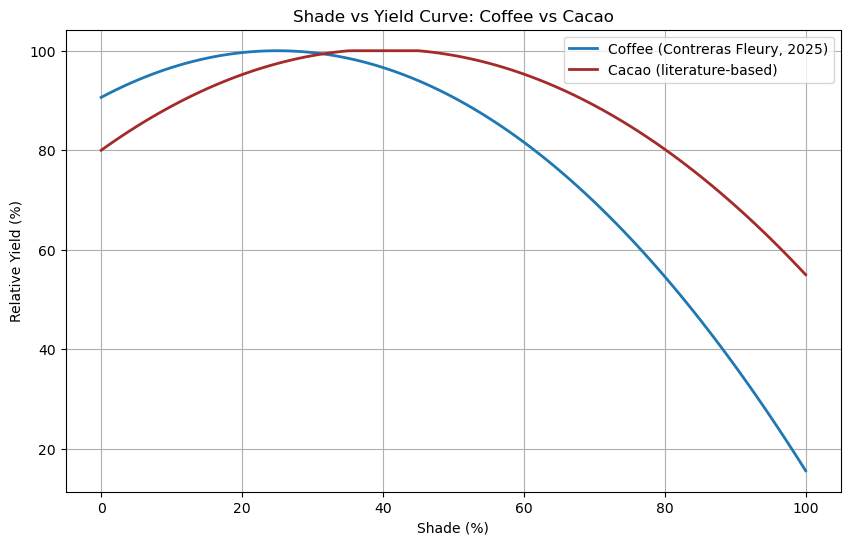

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils_CB import make_cacao_shade_curve


# Load ccoffee curve
shade_vs_yield_curve_file = INPUT_DIR / "Shade_vs_Yield_Curve_coffee.csv"
shade_vs_yield_curve_COFFE = pd.read_csv(shade_vs_yield_curve_file)

# --- Example usage ---
cacao_curve = make_cacao_shade_curve()

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(shade_vs_yield_curve_COFFE['Shade (%)'], shade_vs_yield_curve_COFFE['Yield (%)'],
        label="Coffee (Contreras Fleury, 2025)", lw=2)
ax.plot(cacao_curve['Shade (%)'], cacao_curve['Yield (%)'],
        label="Cacao (literature-based)", lw=2, color="brown")

ax.set_xlabel("Shade (%)")
ax.set_ylabel("Relative Yield (%)")
ax.set_title("Shade vs Yield Curve: Coffee vs Cacao")
ax.legend()
ax.grid(True)

fig.savefig(f"{OUTPUT_DIR}/shade_vs_yield_curve_coffee_vs_cacao.png",
            dpi=300, bbox_inches='tight')
plt.show()


Adjust crop yield based on shade percentage using the helper function below

In [14]:
# Defeine a partial function to estimate new yield for coffee
from functools import partial
from utils_CB import estimate_new_yield

estimate_new_yield_coffe = partial(estimate_new_yield, 
                                    shade_yield_df = shade_vs_yield_curve_COFFE)
estimate_new_yield_cacao = partial(estimate_new_yield, 
                                    shade_yield_df = cacao_curve)

# Example usage - 
current_shade = 40.0  # Current shade in %
current_yield = 1  # Current yield in kg/ha
new_shade = 20.0  # New target shade in %
new_yield = estimate_new_yield_cacao(current_shade, current_yield, new_shade)
print(f"Previous yield: {current_yield:.2f} kg/ha with {current_shade}% shade")
print(f"Estimated new yield: {new_yield:.2f} kg/ha with {new_shade}% shade")

Previous yield: 1.00 kg/ha with 40.0% shade
Estimated new yield: 0.95 kg/ha with 20.0% shade


Derive a function that adjusts the new yield given the canopy change across the canopy DataFrame.

In [15]:
# Example usage of the adjust_yield_based_on_new_tree_shade function with multiple species
from matplotlib.pylab import f
from utils_CB import adjust_yield_based_on_new_tree_shade

prev_crop_df = canopy_crop_dict['present']  # Assuming 'present' is the previous crop DataFrame
new_crop_df = canopy_crop_dict[list(canopy_crop_dict.keys())[1]]  # Using the second sheet as the new crop DataFrame
spec_to_fcn = {
    'Coffea arabica': estimate_new_yield_coffe,
    'Theobroma cacao': estimate_new_yield_cacao  # Assuming the same function for cacao
}
updated_df = adjust_yield_based_on_new_tree_shade(
    prev_crop_df=prev_crop_df,
    new_crop_df=new_crop_df,
    spec_to_fcn=spec_to_fcn
)

print(f"Previous crop DataFrame:")
print(tabulate(prev_crop_df.head(), headers='keys', tablefmt='psql'))

print(f"Updated new crop DataFrame with adjusted yields for multiple species:")
print(tabulate(updated_df.head(), headers='keys', tablefmt='psql'))

Previous crop DataFrame:
+----+-----------+---------------------+------------+-------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+
|    |   Plot ID | Region              |   latitude |   longitude | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   tree_shade |   Plants/ha_baseline |   Added Plants/ha |   Pr

Update the `make_exposure` function so that it uses the `canopy_df` from the given alternative scenario and applies the baseline exposure as a reference to adjust yield levels accordingly.


**Try out:** Show how to create the current and alternative exposures based on `canopy_df`, using the baseline scenario as a reference for adjusting yields.

In [16]:
from utils_CB import make_exposures

# Make the exposures for the 'present' condition
exp_present = make_exposures(canopy_df=canopy_crop_dict['present'],
                         exposure_present= None,
                         spec_to_fcn=spec_to_fcn, 
                         value_unit="USD")

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
#print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

# Make the exposures for the second condition (e.g., 'future' or 'alternative')
alternative_name = list(canopy_crop_dict.keys())[-4]  # Use the second condition
exp_new = make_exposures(canopy_df=canopy_crop_dict[alternative_name],
                         exposure_present=exp_present,
                         spec_to_fcn=spec_to_fcn, 
                         value_unit="USD")
print(f"Exposures object for {alternative_name} condition:")
#print(tabulate(exp_new.gdf, headers='keys', tablefmt='psql'))


# Sum over the 'value' column for Role == 'Main'
total_main_value = exp_present.gdf.loc[exp_present.gdf['Role'] == 'Main', 'value'].sum()
print(f"Total value for Role='Main': {total_main_value:.2f} {exp_present.value_unit}")

# Print the total value of the exposures with role equal to Main 
print(f"Total value for Role= '{alternative_name}': {exp_new.gdf.loc[exp_new.gdf['Role'] == 'Main', 'value'].sum():.2f} {exp_new.value_unit}")

2025-08-29 00:27:26,939 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for 'present' condition:
2025-08-29 00:27:26,964 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
Exposures object for shade_+25 condition:
Total value for Role='Main': 18800.00 USD
Total value for Role= 'shade_+25': 18572.63 USD


### *2.3 – Extra: Shift the peak of the optimal canopy level*

As an additional option, we allow the **optimal canopy peak** (where yield is maximized) to be shifted.  
This adjustment can later be used for **sensitivity analysis**, e.g. testing how results change if the yield–canopy curve is assumed to peak at a higher or lower shade level.

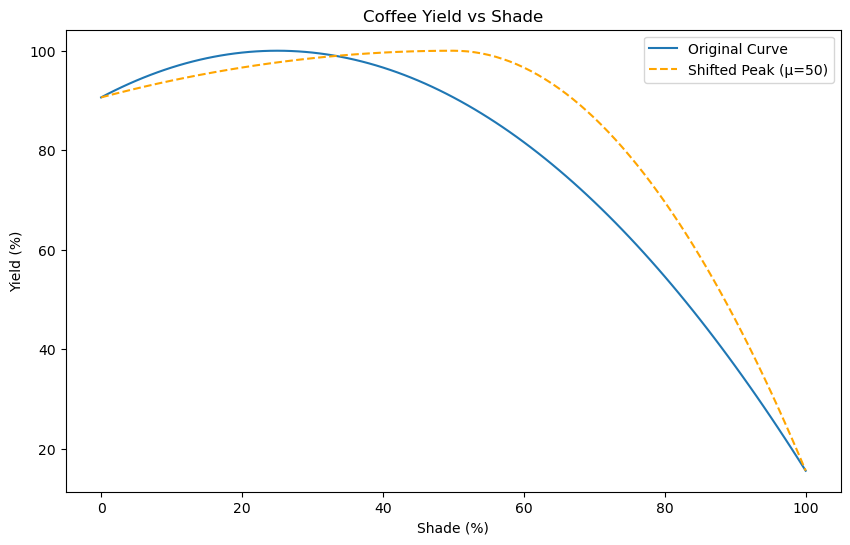

In [17]:
from utils_CB import shift_peak_by_interpolation

# Example usage:
# df_shifted = shift_peak_by_interpolation(df, mu_new=50)

# Example usage:
mu_new = 50   # you could replace this with your random draw
df = shade_vs_yield_curve_COFFE
df_new = shift_peak_by_interpolation(df, mu_new)
# Plotting the original and shifted curves
fig, ax = plt.subplots(figsize=(10, 6))
# Plot both curves on the same axes
shade_vs_yield_curve_COFFE.plot(
    x="Shade (%)", y="Yield (%)", ax=ax, label="Original Curve"
)
df_new.plot(
    x="Shade (%)", y="Yield (%)", ax=ax, label=f"Shifted Peak (μ={mu_new})", linestyle='--', color='orange'
)
# Style
ax.set_title("Coffee Yield vs Shade")
ax.set_ylabel("Yield (%)")
ax.set_xlabel("Shade (%)")
ax.legend()
plt.show()


# 3 – Hazard 

## ☁️ Climate Hazards (VPD & Tmax) — following Kath et al. (2022)

### Data source
We use **TerraClimate** monthly gridded data for:  
- `vpd` (kPa) — vapor pressure deficit  
- `tmax` (°C) — mean monthly maximum temperature  

These variables are aggregated over each crop’s **growing season** on an annual basis.  

The data can be downloaded from [TerraClimate](https://www.climatologylab.org/terraclimate.html) using the notebook [download_terra_climate.ipynb](https://github.com/zeliest/biofincas_climate_risk/blob/main/climate_data/download_terra_climate.ipynb), specifying the parameters `vpd` and `tmax`.  


## 3.1 - Make the Hazards

**Step X – Derive Hazard Set (Mean Seasonal VPD or Tmax)**

We derive the hazard set by **aggregating monthly climate data** into a single value representing the **average hazard intensity during the growing season**.  
This ensures the hazard matches the crop’s phenology (months when yield is determined).

- **Inputs**: Monthly gridded climate data (NetCDF) for VPD or Tmax.  
- **Process**:
  1. Select the relevant variable (`vpd` or `tmax`).  
  2. Subset to the growing season months (e.g., April–November).  
  3. Average across the selected months for each year and grid cell.  
  4. Store results in a hazard object (CLIMADA `Hazard`) with annual time steps.  

- **Outputs**: Hazard set where each event = one season’s average hazard (per year, per location).

In [18]:
from utils_CB import create_hazard_from_nc_files
from pathlib import Path
from climada.hazard import Hazard

# Determine the corresponding parameters for the hazard type
nc_files = {'today': [], 'future': []}
haz_dict  = {}

# ---- choose parameters by hazard type ----
if hazard_type == 'VPD':
    agg    = 'mean'
    varname = 'vpd'
    units   = 'kPa'
    months  = [5,6,7,8,9,10,11]
    nc_files['today']  = sorted(TERRACLIMATE_DIR.glob("terra_climate/TerraClimate_vpd_*_CA.nc"))
    nc_files['future'] = sorted(TERRACLIMATE_DIR.glob(f"terra_climate/TerraClimate_{future_climate_scenario}_vpd_*_CA.nc"))

elif hazard_type == 'Tmax':
    agg    = 'mean'  # use 'max' if you want block maxima + GEV
    varname = 'tmax'
    units   = 'C'
    months  = [5,6,7,8,9,10,11]
    nc_files['today']  = sorted(TERRACLIMATE_DIR.glob("terra_climate/TerraClimate_tmax_*_CA.nc"))
    nc_files['future'] = sorted(TERRACLIMATE_DIR.glob(f"terra_climate/TerraClimate_{future_climate_scenario}_tmax_*_CA.nc"))

In [19]:
# Directory for hazard outputs
INPUT_DIR_HAZARD = INPUT_DIR / "hazards"
INPUT_DIR_HAZARD.mkdir(parents=True, exist_ok=True)

haz_dict = {}
# Build hazards
for key in ["today", "future"]:
    if key == "today":
        haz_file = INPUT_DIR_HAZARD / f"{hazard_type}_historical"
    else:
        haz_file = INPUT_DIR_HAZARD / f"{hazard_type}_{future_climate_scenario}"

    if haz_file.exists():
        print(f"✅ Found existing hazard file: {haz_file}")
        haz_dict[key] = Hazard.from_hdf5(str(haz_file))   # load it instead of regenerating
    else:
        print(f"⚙️ Generating hazard for {key} ...")
        haz_dict[key] = create_hazard_from_nc_files(
            nc_files[key],
            varname=varname,
            haz_type=hazard_type,
            units=units,
            agg=agg,
            months=months,
            nan_replacement=0.0,
            # --- turn on one of these when you want a longer series ---
            synth="bootstrap", synth_kwargs={"n_years": 200, "start_year": 2101, "seed": 42} # best for means; preserves spatial patterns, fast
            # synth="gev", synth_kwargs={"n_years": 200, "start_year": 2101, "invert": False, "coupled": True, "seed": 42}
        )
        haz_dict[key].write_hdf5(str(haz_file))
        print(f"💾 Saved hazard '{key}' to {haz_file}")

    # Plot the intensity of the first event to verify
    #haz_dict[key].plot_intensity(0)


✅ Found existing hazard file: /Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/cost_benefit/Data/hazards/VPD_historical
✅ Found existing hazard file: /Users/viggo/Documents/Programming/Consult/UNU/biofincas_climate_risk/cost_benefit/Data/hazards/VPD_plus2C


# 4 – Impact Function (Vulnerability)

We begin by creating a basic default impact function, which we later adjust based on shade. shade provides a cooling effect that can reduce vulnerability to heat-related losses.

---

**Coffee and Cacao**

Based on our literature review:

- **Coffee**  
  - Highly sensitive to heat above **25 °C**, with yield collapse at extremes (**>42 °C sustained**, ~**49 °C short bursts**).    

- **Cacao**  
  - Tolerates higher average temperatures (up to **27 °C**, absolute maximum ~**38 °C**).  
  - Begins losing photosynthetic function near **37–38 °C**.  

---

As mentioned in *Step 3*, the vulnerability curve for coffee is sourced from:  
[Kath et al. (2022), *Nature Food*](https://www.nature.com/articles/s43016-022-00614-8).


### 4.1 – Get the default impact functions

2025-08-29 00:27:29,589 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


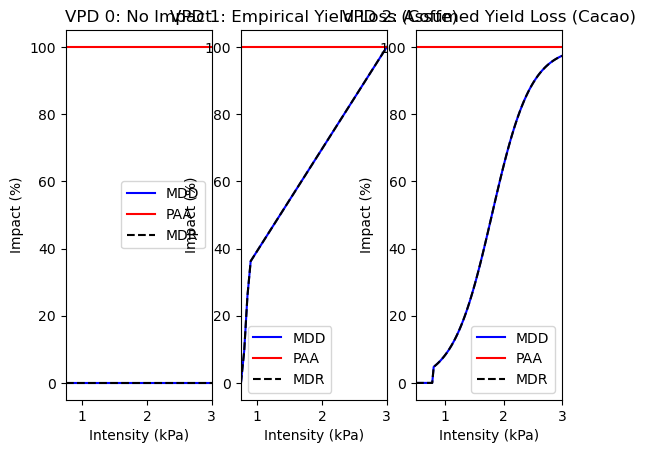

In [20]:
from utils_CB import impact_func_from_kath, extend_to_full_damage, cacao_impf_tmax, cacao_impf_vpd
from climada.entity import ImpactFuncSet
import copy


# Create an ImpactFuncSet with the VPD impact function
imp_fun_set_base = ImpactFuncSet()

## Make the impact function for coffee with id 1 
# Coffe has id # 1, Banana has id 2, Cacao has id 3
if hazard_type.upper() == 'TMAX':
    # Coffee impact function based on Tmax
    impf_coffe = impact_func_from_kath(
        file_path= "Data/tasmax_effect_approximation_coffe.csv",
        intensity_col="Mean_Tasmax_C", 
        yield_col="Upper_Bound", # Upper_Bound, Effect_Central or Lower_Bound – Represnting the confidence intervals of the yield loss –You can choose based on your preference of vulnerability
        haz_type="Tmax",
        unit="°C",
        if_id= 1,
        name="Empirical Yield Loss (Coffe)"
    )
    # Extend the coffee impact function to full damage
    impf_coffe = extend_to_full_damage(impf_coffe, x_full=40.0) 
    # Cacao impact function based on Tmax
    impf_cacao = cacao_impf_tmax(
        T=impf_coffe.intensity,
        if_id=2,
        name="Assumed/Prior Yield Loss (Cacao)"
    )
elif hazard_type.upper() == 'VPD':
    # Coffee impact function based on VPD
    impf_coffe = impact_func_from_kath(
        file_path= "Data/vpd_effect_approximation.csv",
        intensity_col="Mean_VPD_kPa",
        yield_col="Upper_Bound", # Upper_Bound, Effect_Central or Lower_Bound – Represnting the confidence intervals of the yield loss –You can choose based on your preference of vulnerability
        haz_type="VPD",
        unit="kPa",
        if_id= 1,
        name="Empirical Yield Loss (Coffe)"
    )
    # Extend the coffee impact function to full damage
    impf_coffe = extend_to_full_damage(impf_coffe, x_full=3.0)
    # Cacao impact function based on VPD
    impf_cacao = cacao_impf_vpd(
        V=impf_coffe.intensity,
        if_id=2,
        name="Assumed/Prior Yield Loss (Cacao)"
    )

# Adjust the impact function intensity to be zero before the increasing values to only account for negative impacts to account for heat stress
for idx, value in enumerate(impf_coffe.mdd):
   # print(f"Index: {idx}, Value: {value}")
    #print(f"Intensity: {impf_coffe.mdd}")
    if value > 0:
        impf_coffe.mdd[idx] = 0.0
    else:
        break


## Make the non impact function for coffee with id 0
impf_zero = copy.deepcopy(impf_coffe)
impf_zero.id = 0  # Set the ID to 0 for no impact
impf_zero.name = "No Impact"
impf_zero.mdd = np.zeros_like(impf_coffe.mdd)  # Set all values to zero

# Make the cacao impact function based on the assumption that it is the same as coffee
# This is a prior assumption, not based on empirical data
# Adjust the intensity to be zero before the increasing values to only account for negative impacts
impf_cacao = cacao_impf_tmax() if hazard_type.upper() == 'TMAX' else cacao_impf_vpd()
#copy.deepcopy(impf_coffe)
impf_cacao.id = 2
impf_cacao.name = "Assumed Yield Loss (Cacao)"


# Add the impact function to the ImpactFuncSet
imp_fun_set_base.append(impf_zero)
imp_fun_set_base.append(impf_coffe)
imp_fun_set_base.append(impf_cacao)

# Plot the impact function set
ax = imp_fun_set_base.plot()
plt.show()

# ax is the ndarray of Axes you showed
fig = ax.ravel()[0].get_figure()   # or ax[0].get_figure()

fig.tight_layout()
fig.savefig(OUTPUT_DIR / "impact_functions_VPD.png",
            dpi=300, bbox_inches="tight")
plt.close(fig)  # optional: free memory

**Create a DataFrame** to store the default impact function IDs, where:

- `0` → No impact (unknown imapct function)
- `1` → Coffee  
- `2` → Cacao


In [21]:
import pandas as pd

# Species categories
coffee_species = ['Coffea arabica']
cacao_species  = ['Theobroma cacao']

# Get all species in exposure
all_species = exp_present.gdf['Scientific name'].unique().tolist()

# Build mapping: 0 = default, 1 = coffee, 2 = cacao
default_impact_function_id = {
    1: coffee_species,
    2: cacao_species,
    0: [s for s in all_species if s not in coffee_species + cacao_species]
}

# Flatten to DataFrame
records = [
    {'Scientific name': species, 'impf_id_default': impf_id}
    for impf_id, species_list in default_impact_function_id.items()
    for species in species_list
]
impf_default_df = pd.DataFrame(records)

print("Default Impact Function DataFrame:")
print(tabulate(impf_default_df.head(), headers='keys', tablefmt='psql'))


Default Impact Function DataFrame:
+----+-------------------+-------------------+
|    | Scientific name   |   impf_id_default |
|----+-------------------+-------------------|
|  0 | Coffea arabica    |                 1 |
|  1 | Theobroma cacao   |                 2 |
|  2 | Persea americana  |                 0 |
|  3 | Musa spp.         |                 0 |
|  4 | Citrus aurantium  |                 0 |
+----+-------------------+-------------------+


### 4.2 Add mapped impact function IDs to the exposure, based on site and canopy level


In [22]:
from utils_CB import generate_custom_impact_function_IDs_by_canopy_df

# Example usage
df_impf_id_map = generate_custom_impact_function_IDs_by_canopy_df(
    impf_default_df=impf_default_df,
    canopy_df= canopy_crop_dict['present'],
    hazard_type=hazard_type
)

# Print the DataFrame with new impact function IDs
print("DataFrame with new impact function IDs:")
print(tabulate(df_impf_id_map.head(), headers='keys', tablefmt='psql'))

DataFrame with new impact function IDs:
+----+-----------+--------------------+-------------------+------------+
|    |   site_id | Scientific name    |   impf_id_default |   impf_VPD |
|----+-----------+--------------------+-------------------+------------|
|  0 |         0 | Persea americana   |                 0 |          0 |
|  1 |         0 | Musa spp.          |                 0 |          0 |
|  2 |         0 | Citrus aurantium   |                 0 |          0 |
|  3 |         0 | Artocarpus altilis |                 0 |          0 |
|  4 |         0 | Theobroma cacao    |                 2 |          3 |
+----+-----------+--------------------+-------------------+------------+


Add the impf_Tmax to the exposure id for each canopy

In [23]:
from climada.entity import Exposures

def make_exposures_from_canopy_df(
    canopy_df: pd.DataFrame,
    exposure_present: Exposures = None,
    spec_to_fcn: dict = None,
    value_unit: str = "USD",
    impf_default_df=impf_default_df,
    ignore_impf_ids=[0],
    hazard_type: str = hazard_type
) -> Exposures:
    """
    Create an Exposures object from a canopy DataFrame.

    Args:
        canopy_df (pd.DataFrame): DataFrame containing canopy data.
        exposure_present (Exposures): Base exposures to use for the new exposures.
        spec_to_fcn (dict): Dictionary where keys are scientific name(s) (str or list),
                            and values are functions that estimate new yield.
        value_unit (str): Unit of value for the exposures.

    Returns:
        Exposures: An Exposures object with the provided data.
    """

    # Get the custom impact function IDs from the canopy DataFrame
    df_impf_id_map = generate_custom_impact_function_IDs_by_canopy_df(
        impf_default_df=impf_default_df,
        canopy_df=canopy_df,
        hazard_type=hazard_type,
        ignore_impf_ids= ignore_impf_ids
    )
    
    # Add to the canopy DataFrame
    canopy_df = canopy_df.merge(df_impf_id_map[['site_id', 'Scientific name', f'impf_{hazard_type}']],
                                on=['site_id', 'Scientific name'],
                                how='left')
   
    # make the exposures
    exp = make_exposures(
        canopy_df=canopy_df,
        exposure_present=exposure_present,
        spec_to_fcn=spec_to_fcn,
        value_unit=value_unit
    )

    return exp


**Try the function** and verify that the generated exposure also includes an assigned impact function ID.

In [24]:
# Example usage 
exp_present = make_exposures_from_canopy_df(canopy_df = canopy_crop_dict['present'],
                                            exposure_present= None,
                                            spec_to_fcn = spec_to_fcn)

# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf.head(), headers='keys', tablefmt='psql'))

Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   tree_sha

### 4.3 Adjust the impact function for cooling effects and create unique impact function sets for each compositions

**Create an adjustment function** that modifies the hazard intensity based on shade, reflecting the cooling and protective effects of increased shade.

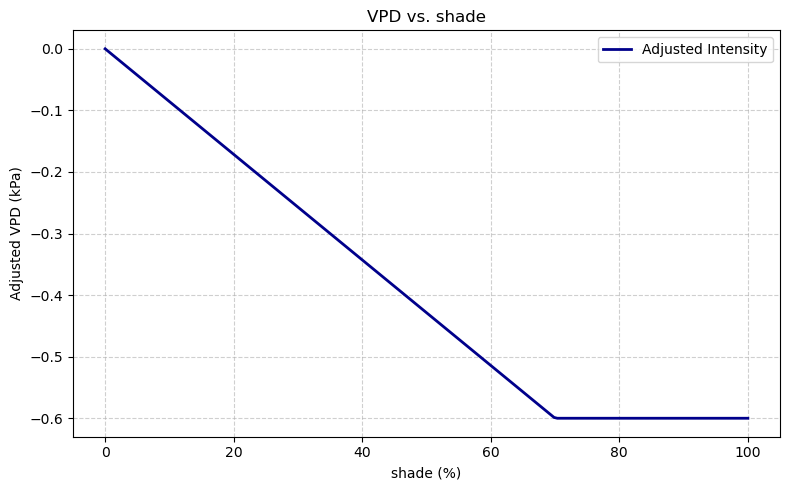

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from utils_CB import helper_create_adj_func

# Example for plotting
canopy = np.linspace(0, 100, 200)
if hazard_type.upper() == 'TMAX':
    base_intensity = 0  # °C
    adjust_fcn = helper_create_adj_func()
    ylabel = "Adjusted Temperature (°C)"
    title = "Tmax vs. shade"
elif hazard_type.upper() == 'VPD':
    base_intensity = 0  # kPa
    adjust_fcn = helper_create_adj_func(sensitivity=-0.15)
    ylabel = "Adjusted VPD (kPa)"
    title = "VPD vs. shade"
else:
    raise ValueError("Unsupported hazard type")

# Calculate adjusted values
adj_intensity = adjust_fcn(base_intensity, canopy)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(canopy, adj_intensity, label="Adjusted Intensity", color="darkblue", linewidth=2)
plt.title(title)
plt.xlabel("shade (%)")
plt.ylabel(ylabel)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
fig = plt.gcf()  # <-- get current figure
fig.savefig(f"{OUTPUT_DIR}/canopy_cooling_curve.png", dpi=300, bbox_inches='tight')
plt.show()


**Create a function** that adjusts the impact function using the previously defined hazard intensity adjustment function, updating vulnerability curves accordingly.

Demonstrate the adjusted imapct function

<Axes: title={'center': 'VPD 1: Adjusted Impact Function (Coffe)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>

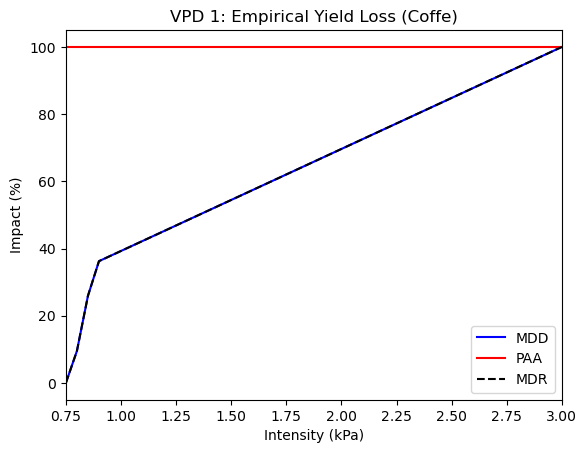

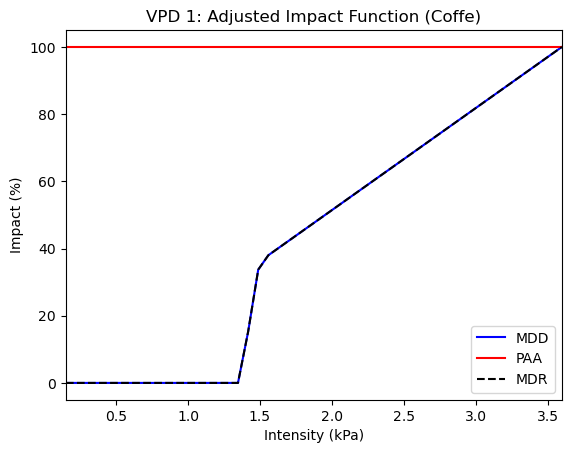

In [26]:
from utils_CB import adjust_impf_by_canopy

new_id = 1
adj_impf = adjust_impf_by_canopy(impf_coffe, adjust_fcn, new_id, current_canopy=70, new_name="Adjusted Impact Function (Coffe)")

impf_coffe.plot()
adj_impf.plot()

**Create a function** that generates a unique impact function set for each canopy composition, incorporating canopy-based adjustments to hazard intensity and vulnerability.

In [27]:
def create_adjusted_impact_function_set(
    canopy_df: pd.DataFrame,
    adjust_fcn,
    imp_fun_set_base: ImpactFuncSet = imp_fun_set_base,
    df_impf_id_map: pd.DataFrame = df_impf_id_map,
    hazard_type: str = hazard_type,
    ignore_impf_ids: list = [0]  # Default to ignoring ID 0 (no impact) if not specified
):
    """
    Create adjusted impact functions using pre-assigned IDs and shade.

    Args:
        df_impf_id_map (pd.DataFrame): Must contain ['site_id', 'Scientific name', 'impf_id_default', 'impf_{hazard_type}']
        df_site_canopy (pd.DataFrame): Must contain ['site_id', 'Scientific name', 'tree_shade']
        imp_fun_set_base (ImpactFuncSet): Original function set.
        adjust_fcn (function): Canopy adjustment function.
        hazard_type (str): Hazard type (e.g., "TMAX")

    Returns:
        ImpactFuncSet: New ImpactFuncSet with adjusted functions added.
    """
    # get the site_id and scientific name from the canopy_df
    df_site_canopy = canopy_df[['site_id', 'Scientific name', 'tree_shade']].drop_duplicates()


    # Merge shade into the ID mapping DataFrame
    df_merged = df_impf_id_map.merge(
        df_site_canopy,
        on=['site_id', 'Scientific name'],
        how='left'
    )

    # Copy original function set
    imp_fun_set_new = copy.deepcopy(imp_fun_set_base)
    seen_ids = set()

    # Iterate through the merged DataFrame to create adjusted functions
    for _, row in df_merged.iterrows():
        site_id = row['site_id']
        base_id = row['impf_id_default']
        new_id = row[f'impf_{hazard_type}']
        canopy = row['tree_shade']


        if pd.isna(new_id) or new_id in ignore_impf_ids or new_id in seen_ids:
            # Skip if no new ID or already seen
            continue

        base_impf = imp_fun_set_base.get_func(hazard_type, base_id) # Get the base impact function by hazard type and ID
        adjusted_func = adjust_impf_by_canopy(
            base_impf,
            adjust_fcn=adjust_fcn,
            new_id=new_id,
            current_canopy=canopy, 
            new_name=f"{row['Scientific name']} site {site_id}"
        )

        imp_fun_set_new.append(adjusted_func)
        seen_ids.add(new_id)

    return imp_fun_set_new

Try out the function

array([[<Axes: title={'center': 'VPD 0: No Impact'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 3: Theobroma cacao site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 4: Coffea arabica site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 5: Theobroma cacao site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 6: Coffea arabica site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 7: Theobroma cacao site 2'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 8: Coffea arabica site 2'}, xlabel='Intensity (kPa)'

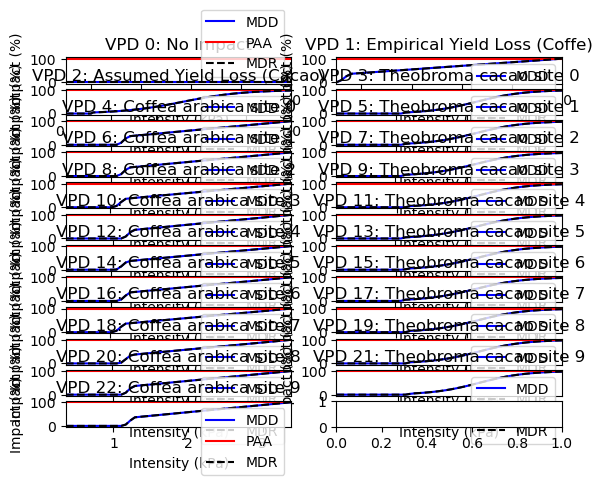

In [28]:
adjusted_impf_set = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict[list(canopy_crop_dict.keys())[0]],  # Use the first sheet as the base
    adjust_fcn=adjust_fcn
)

adjusted_impf_set.plot()

# 5 – Cost and Income

In CLIMADA there is a new Cost–Income object that supports cost–benefit analysis
by combining revenue streams and cost structures, making it easier to evaluate
adaptation measures in a consistent way.

In this notebook we take a simplified approach:
 - In the `canopy_df` we have already attributed planting and maintenance costs
   to the added (new) and reduced (removed) trees.
 - These costs are then treated separately as planting and maintenance,
   linked to canopy composition changes.

*Disclosure*: For simplicity, we do not use the full Cost–Income object here.
Instead, we apply discounting via the `DiscountRate` object to obtain the
net present value (NPV) of costs and revenues.


Read the costs from the canopy data frame

In [29]:
from utils_CB import make_cashflows_costs

# Import the canopy price data
costs_df = canopy_crop_dict['present'][['Scientific name', 'Planting cost (per tree)', 'Maintenance cost (per tree)']].drop_duplicates()

for comp, df in canopy_crop_dict.items():
    cost_cashflows_df, npv_dict = make_cashflows_costs(df, costs_df)
    print(f"Cashflows for '{comp}':")
    print(tabulate(cost_cashflows_df.head(), headers='keys', tablefmt='psql'))
    print(f"Net Present Value (NPV) for '{comp}':")
    print(tabulate(pd.DataFrame([npv_dict]).head(), headers='keys', tablefmt='psql'))
    print("\n")

Cashflows for 'present':
+----+--------+------------+---------+---------+
|    |   year |   Previous |   Added |   total |
|----+--------+------------+---------+---------|
|  0 |   2025 |      828.1 |       0 |   828.1 |
|  1 |   2026 |      828.1 |       0 |   828.1 |
|  2 |   2027 |      828.1 |       0 |   828.1 |
|  3 |   2028 |      828.1 |       0 |   828.1 |
|  4 |   2029 |      828.1 |       0 |   828.1 |
+----+--------+------------+---------+---------+
Net Present Value (NPV) for 'present':
+----+------------+---------+---------+
|    |   Previous |   Added |   total |
|----+------------+---------+---------|
|  0 |    21530.6 |       0 | 21530.6 |
+----+------------+---------+---------+


Cashflows for 'shade_-50':
+----+--------+------------+---------+---------+
|    |   year |   Previous |   Added |   total |
|----+--------+------------+---------+---------|
|  0 |   2025 |      415.6 |       0 |   415.6 |
|  1 |   2026 |      415.6 |       0 |   415.6 |
|  2 |   2027 |      

Calculate the cost income object

In [30]:
from utils_CB import make_cost_income_from_canopy_df

# Example usage
cost_income = make_cost_income_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],  # Use the 'present' condition
    costs_df=costs_df,  # Costs DataFrame
    column='Added'  # Column to use for cashflows ('Added' or 'total')
)

# 6 – Discount Rates

Used for discounting future costs and revenues in the cost–benefit analysis.

<Axes: title={'center': 'Discount rates'}, xlabel='Year', ylabel='discount rate (%)'>

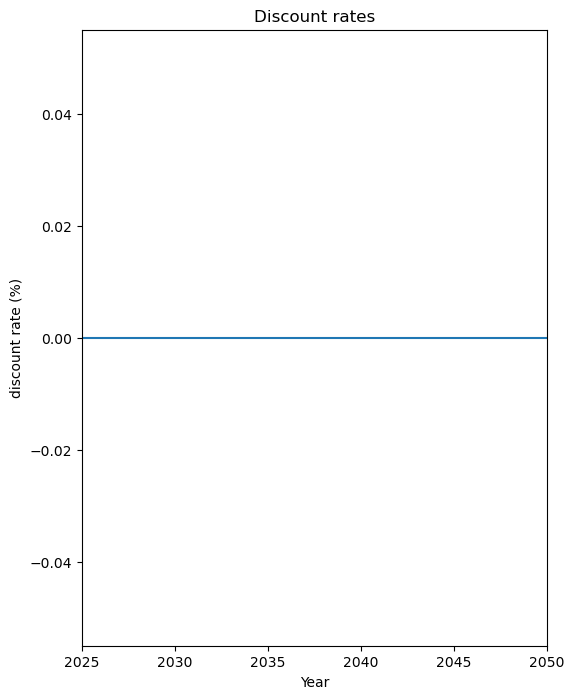

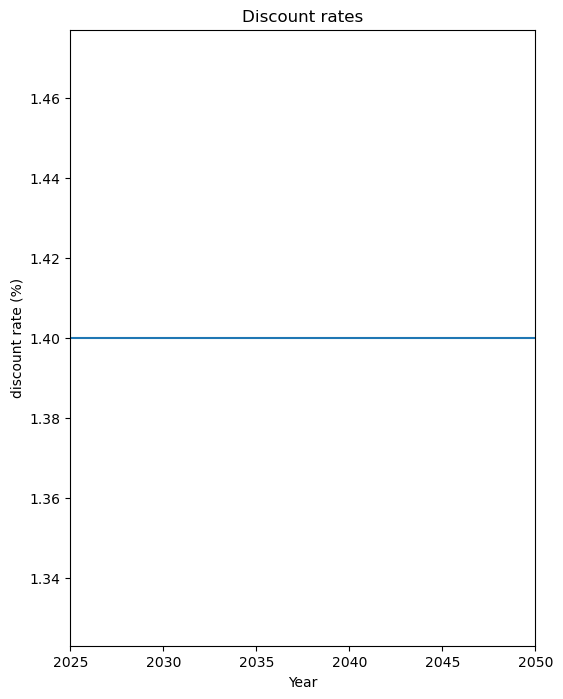

In [31]:
from climada.entity import DiscRates
from utils_CB import PRESENT_YEAR, FUTURE_YEAR

year_range = np.arange( PRESENT_YEAR, FUTURE_YEAR + 1)
n_years = len(year_range)
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

# Create discount rates with zero and Stern's discount rates
discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)
# Plot the discount rates
discount_zero.plot(label='Zero Discount Rate')
discount_stern.plot(label='Stern Discount Rate')

Decide on a discount rate

In [32]:
# Create the entity for the present climate scenario
disc_rate = discount_zero  # discount_zero or discount_stern

## 7 – Measures

In the new CLIMADA update, measures can now makes use of *mapper functions* that transform a CLIMADA object (Exposure, Hazard, or Impact Function Set) into a modified version of the same type.

In our case, the `canopy_df` – which encodes the canopy composition of an  
alternative scenario – acts as the driver of the measure:

- It modifies the **Exposure** object by changing crop values and areas according to yield–shade relationships.  
- It modifies the **Impact Function Set** by adjusting vulnerability curves (e.g. reduced Tmax/VPD sensitivity under higher shade).  
- The **Hazard** object itself is unchanged, but the effective hazard intensity is perceived differently due to the adjusted vulnerability.  

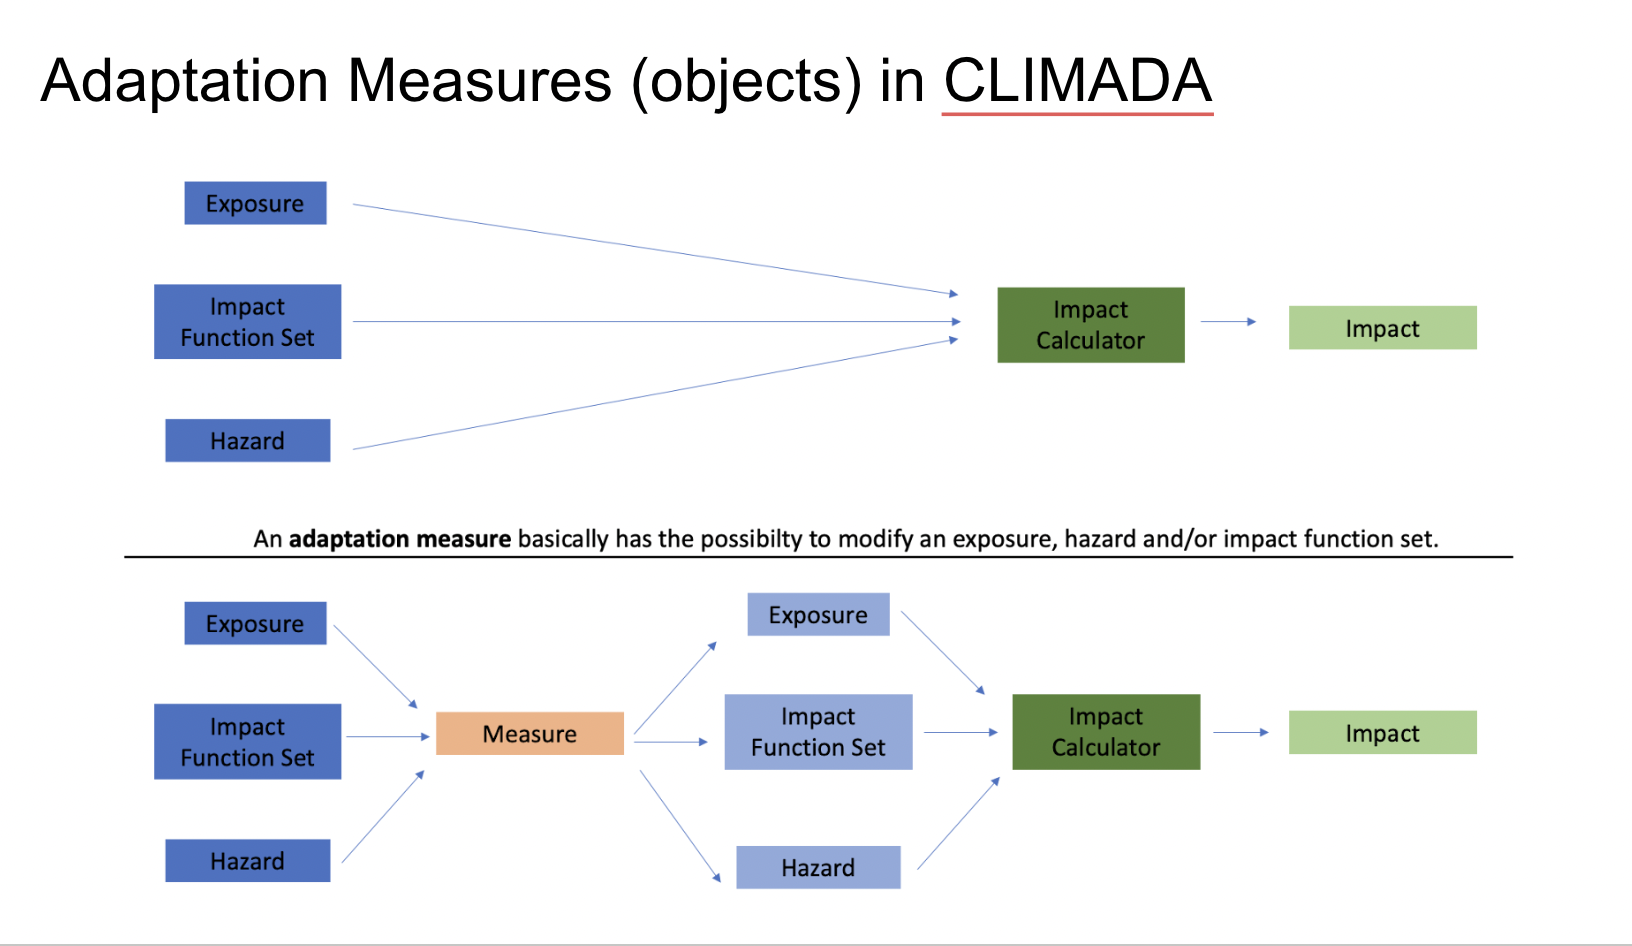

### 7.1 Make the mappers

#### 7.1.1 Make the exposure mapper

In [33]:
from typing import Optional
# from climada.entity import Exposures

def make_exposure_mapper(
    canopy_df: pd.DataFrame,
    spec_to_fcn: dict,
):
    """
    Returns a function exp_mapper(exposure_present_, year) -> Exposures
    with all other arguments fixed from this scope.
    """

    def exp_mapper( exposure_present: Optional["Exposures"] = None,
                    year: Optional[int] = None
                    ):
        return make_exposures_from_canopy_df(
            canopy_df=canopy_df,
            exposure_present=exposure_present,
            spec_to_fcn=spec_to_fcn,
        )

    return exp_mapper


Try the mapper

In [34]:
# present exposures (baseline)
exp_present = make_exposures_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],
    spec_to_fcn=spec_to_fcn
)
# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf.head(), headers='keys', tablefmt='psql'))

# mapper that will (for now) ignore `year` but keeps a compatible signature
# Make the exposures for the second condition (e.g., 'future' or 'alternative')
alternative_name = list(canopy_crop_dict.keys())[2]  # Use the second condition
exp_mapper = make_exposure_mapper(
    canopy_df=canopy_crop_dict[alternative_name],
    spec_to_fcn=spec_to_fcn
)

# later in your code
exp_new = exp_mapper(exposure_present=exp_present)  # year ignored
# Print the Exposures object to verify
print(f"Exposures object for {alternative_name}") 
print(tabulate(exp_new.gdf.head(), headers='keys', tablefmt='psql'))



Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+-------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species           | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade (%) |   tree_sha

Check how the production changes with the different alterantives

In [35]:
from tabulate import tabulate

func = make_exposures # or make_exposures_from_canopy_df
# Loop through each canopy_df in the dictionary
for comp_name, canopy_df in canopy_crop_dict.items():
    # Make exposures
    if comp_name == 'present':
        exp = func(
            canopy_df=canopy_df,
            spec_to_fcn=spec_to_fcn
        )
    else:
        exp = func(
            canopy_df=canopy_df,
            exposure_present=exp_present,  # Use the previous exposures as base
            spec_to_fcn=spec_to_fcn
        )
    
    # Calculate sums
    total_value = exp.gdf['value'].sum()
    total_main_value = exp.gdf.loc[exp.gdf['Role'] == 'Main', 'value'].sum()
    
    # Print results
    print(f"=== {comp_name} ===")
    print(f"Total value: {total_value:.2f} {exp.value_unit}")
    print(f"Total value (Role='Main'): {total_main_value:.2f} {exp.value_unit}")
    print()


2025-08-29 00:27:31,267 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== present ===
Total value: 57992.00 USD
Total value (Role='Main'): 18800.00 USD

2025-08-29 00:27:31,274 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-50 ===
Total value: 37473.70 USD
Total value (Role='Main'): 17907.70 USD

2025-08-29 00:27:31,277 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-30 ===
Total value: 46168.16 USD
Total value (Role='Main'): 18512.16 USD

2025-08-29 00:27:31,281 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-25 ===
Total value: 47977.01 USD
Total value (Role='Main'): 18607.01 USD

2025-08-29 00:27:31,285 - climada.entity.exposures.base - WARNING - There are no impact functions assigned to the exposures
=== shade_-20 ===
Total value: 49978.39 US

#### 7.1.2 Make the impact function set mapper

array([[<Axes: title={'center': 'VPD 0: No Impact'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 3: Theobroma cacao site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 4: Coffea arabica site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 5: Theobroma cacao site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 6: Coffea arabica site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 7: Theobroma cacao site 2'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 8: Coffea arabica site 2'}, xlabel='Intensity (kPa)'

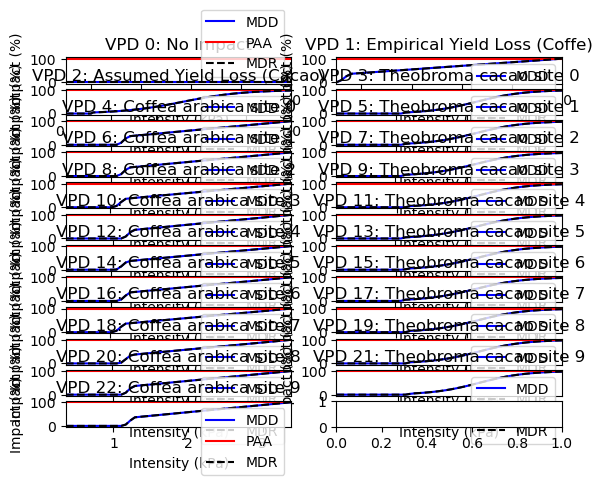

In [36]:
from typing import Optional
import pandas as pd
from climada.entity import ImpactFuncSet

def make_impf_set_mapper(
    canopy_df: pd.DataFrame,
    adjust_fcn,
    imp_fun_set_base: ImpactFuncSet
):
    """
    Returns a function impf_set_mapper(imp_fun_set_base, year) -> ImpactFuncSet
    with all other arguments fixed from this scope.
    """

    def impf_set_mapper(
        imp_fun_set: ImpactFuncSet,
        year: Optional[int] = None
    ) -> ImpactFuncSet:
        return create_adjusted_impact_function_set(
            canopy_df=canopy_df,
            imp_fun_set_base=imp_fun_set_base,
            adjust_fcn=adjust_fcn,
        )

    return impf_set_mapper


adjusted_impf_set = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict[list(canopy_crop_dict.keys())[0]],  # Use the first sheet as the base
    imp_fun_set_base=imp_fun_set_base,
    adjust_fcn=adjust_fcn
)

adjusted_impf_set.plot()

array([[<Axes: title={'center': 'VPD 0: No Impact'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 3: Theobroma cacao site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 4: Coffea arabica site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 5: Theobroma cacao site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 6: Coffea arabica site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 7: Theobroma cacao site 2'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 8: Coffea arabica site 2'}, xlabel='Intensity (kPa)'

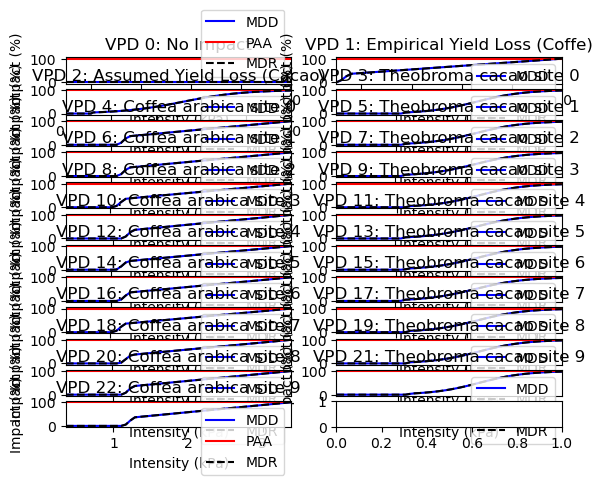

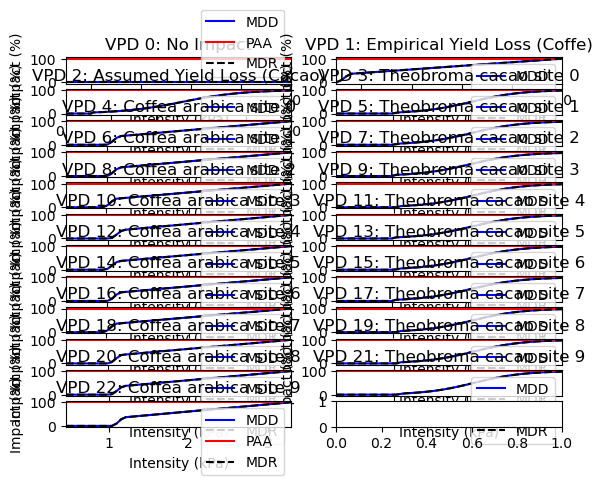

In [37]:
# Get the impact fucntion set for the present compostition
impf_set_present =  create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict['present'],  # Use the first sheet as the base
    adjust_fcn=adjust_fcn
)

# Get the impact fucntion set for the alternatvie
alternative_name = list(canopy_crop_dict.keys())[3]  # Use the second condition
impf_set_mapper = make_impf_set_mapper(canopy_df= canopy_crop_dict[alternative_name],
                                       adjust_fcn = adjust_fcn,
                                       imp_fun_set_base = imp_fun_set_base
)


new_impf_set = impf_set_mapper(impf_set_present)

impf_set_present.plot()
new_impf_set.plot()

### 7.2 Define the measures

In [38]:
from climada.engine.option_appraisal.appraiser import MeasuresAppraiser

# Define the measure
from climada.entity.measures.base import Measure
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome

In [39]:
# Define a measure list
meas_list = []

# Make the measures for each composition in the canopy_crop_dict except 'present'
for comp in canopy_crop_dict.keys():
    if comp == 'present':
        continue
    else:
        # Get the canopy DataFrame for the composition
        canopy_df = canopy_crop_dict[comp]
        # Define the measure
        meas = Measure( haz_type= hazard_type,  # Use the hazard type defined earlier
                        name = comp,
                        # Make the exposures mapper
                        exposures_change = make_exposure_mapper(canopy_df=canopy_df,
                                                                spec_to_fcn=spec_to_fcn
                                                                ),
                        # Make the impact function set mapper
                        impfset_change = make_impf_set_mapper(canopy_df= canopy_df,
                                                                adjust_fcn = adjust_fcn,
                                                                imp_fun_set_base=imp_fun_set_base
                                                                ),
                        # Make the cost income from the canopy_df and costs_df
                        #cost_cashflows_df, _ = make_cashflows_costs(canopy_df, costs_df, years=10)
                        cost_income = make_cost_income_from_canopy_df(canopy_df=canopy_crop_dict[comp],
                                                                        costs_df=costs_df,
                                                                        column='Added'  # 'Added' or 'total'
                                                                    )
                        )
        # Add to the measure list
        meas_list.append(meas)


Try the measures

Exposures object for 'present' condition:
+----+-----------+---------------------+----------+------------------+---------------------------+--------------------+-----------+-------------+------------+----------------+---------------------+----------------------+------------------------+----------------------------+-------------------------------+-----------+-------------------------------+--------------------------+------------------+--------------+----------------------+-------------------+----------------------+------------+------------------+---------+----------------------------------------------+
|    |   Plot ID | Region              | System   |   Plot size (ha) | Species                   | Scientific name    | Role      |   Plants/ha |   Kg/plant |   Tonnes/plant |   Yield (t/ha/year) |   Price/tonnes (USD) |   Per-tree shading (%) |   Planting cost (per tree) |   Maintenance cost (per tree) |   site_id |   Per-tree shading (%) scaled |   Shade contribution (%) |   Tree Shade 

array([[<Axes: title={'center': 'VPD 0: No Impact'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 1: Empirical Yield Loss (Coffe)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 2: Assumed Yield Loss (Cacao)'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 3: Theobroma cacao site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 4: Coffea arabica site 0'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 5: Theobroma cacao site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 6: Coffea arabica site 1'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>,
        <Axes: title={'center': 'VPD 7: Theobroma cacao site 2'}, xlabel='Intensity (kPa)', ylabel='Impact (%)'>],
       [<Axes: title={'center': 'VPD 8: Coffea arabica site 2'}, xlabel='Intensity (kPa)'

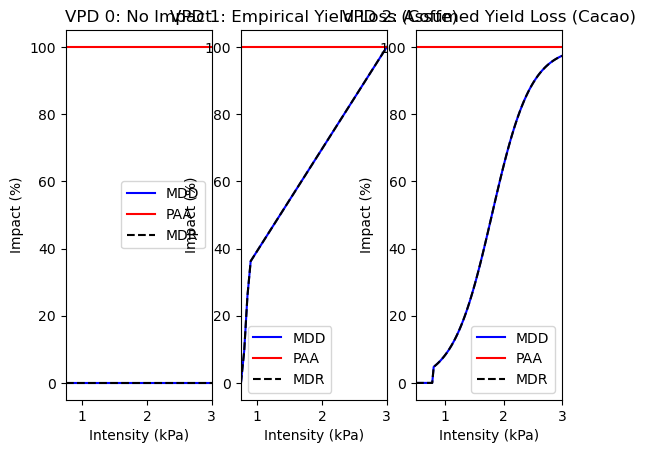

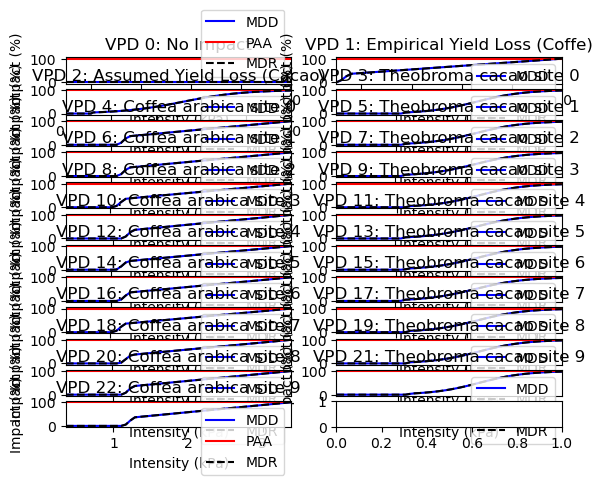

In [40]:
exp_new, impf_set_new, haz_new = meas.apply(exposures = exp_present,
                                            impfset = imp_fun_set_base,
                                            hazard = haz_dict['today']  # Use the hazard for today (or 'present' condition
)


# Print the Exposures object to verify
print("Exposures object for 'present' condition:")
print(tabulate(exp_present.gdf, headers='keys', tablefmt='psql'))

# Print the Exposures object to verify
print(f"Exposures object for {alternative_name}") 
print(tabulate(exp_new.gdf, headers='keys', tablefmt='psql'))

imp_fun_set_base.plot()
impf_set_new.plot()

In [41]:
# Gather all measures in a measure set
meas_set = MeasureSet(measures=meas_list)

# 8 – Cost and Revenue Estimates (Add Average Canopy)

In this stage, we manually calculate the costs and benefits by estimating yield for both the present and the future under different canopy scenarios.  
To calculate the future yield, we account for the risk difference between scenarios, adjusting for changes in shade.


### 8.1 – Calculate Impacts

- Compute the **Annual Average Loss (AAL)** to estimate the expected NPV.  
- Calculate the **return period (RP)** losses to reflect revenue in a bad year.

In [42]:
from calendar import c
from climada.engine import ImpactCalc

# Initialize dictionaries to store results:
# - impacts_dict will hold Impact objects for each scenario and composition
# - exp_dict will hold Exposure objects for each scenario and composition
impacts_dict = {
    'today': {},   # Impacts for present-day baseline and measures
    'future': {}   # Impacts for future climate conditions
}
exp_dict = copy.deepcopy(impacts_dict)

# --- Create baseline (present) exposure and impact function set ---

# Create an adjusted impact function set for the present condition
# This modifies the base impact functions according to shade (cooling effect)
impf_set_present = create_adjusted_impact_function_set(
    canopy_df=canopy_crop_dict['present'],
    adjust_fcn=adjust_fcn,                     # Function to adjust impact curve by canopy
    imp_fun_set_base=imp_fun_set_base          # Base impact function set (unadjusted)
)

# Create the exposure object for the present condition
# This assigns asset values and metadata to each site based on the present canopy composition
exp_present = make_exposures_from_canopy_df(
    canopy_df=canopy_crop_dict['present'],
    spec_to_fcn=spec_to_fcn                     # Mapping from species to impact function ID
)

# --- Loop over climate scenarios ('today' and 'future') ---
for climate_scenario in ['today', 'future']:
    haz = haz_dict[climate_scenario]  # Select hazard object for this scenario

    # Loop over all canopy compositions (baseline + adaptation measures)
    for comp in canopy_crop_dict.keys():

        # If this is the baseline 'present' composition, use the already prepared exposure and IFS
        if comp == 'present':
            exp = exp_present
            ifs = impf_set_present

        # If this is an alternative composition (adaptation measure)
        else:
            meas = meas_set.measures()[comp]     # Retrieve the measure object by name
            # Apply the measure to the present exposure & impact functions
            # This can modify exposure (e.g., yield, value), impact functions, and hazards
            exp, ifs, _ = meas.apply(exp_present, impf_set_present, haz)

        # --- Calculate and store results ---
        # Compute the impact for this exposure, impact function set, and hazard
        impacts_dict[climate_scenario][comp] = ImpactCalc(exp, ifs, haz).impact(save_mat=False)

        # Store the exposure (only for 'today' scenario to avoid duplication)
        if climate_scenario == 'today':
            exp_dict[climate_scenario][comp] = exp


### 8.2 – Calculate the Cost and Revenue Metrics

In this step, compute the key financial metrics for each canopy composition and climate scenario, including:  
- **Total Costs** – Planting, maintenance, and replacement over the analysis period.  
- **Total Revenues** – Estimated from yield–canopy relationships and adjusted for hazard impacts.  
- **Net Present Value (NPV)** – Discounted costs and revenues over time.  
- **Benefit–Cost Ratio (BCR)** – Ratio of total benefits to total costs.  
- **Net Benefits** – Revenues minus costs after discounting.

We perform this step-wise, as the future revenue is estimated based on the change in climate risk.  
We begin by retrieving the **Annual Average Loss (AAL)** and **return period losses** for each scenario to quantify  
expected revenue reductions in both normal and bad years.

In [43]:
import pandas as pd
from numpy import interp

rows = []

return_period = 100  # Example return period in years (used for bad-year loss calculation)

# Loop over all canopy compositions for the 'today' scenario
for comp in impacts_dict['today'].keys():

    # --- COSTS ---
    # Calculate the net present value (NPV) of total costs for this composition
    # make_cashflows_costs() returns a tuple, where index [1]['total'] is the NPV of total costs
    npv_total = make_cashflows_costs(
        canopy_df=canopy_crop_dict[comp],  # canopy composition DataFrame
        costs_df=costs_df,                 # cost data
        disc_rate=disc_rate                 # discount rate
    )[1]['total']

    # --- REVENUES (Present Scenario) ---
    # Get the exposure GeoDataFrame for 'today' and this composition
    exp_today = exp_dict['today'][comp].gdf

    # Total average annual revenue (sum of all site values)
    total_today = exp_today['value'].sum()

    # Average revenue for main crop only
    total_main = exp_today.loc[exp_today['Role'] == 'Main', 'value'].sum()

    # Average revenue for secondary crops
    total_secondary = exp_today.loc[exp_today['Role'] == 'Secondary', 'value'].sum()

    # --- AAL (Annual Average Loss) ---
    # Aggregate AAL (total) for today and future
    aal_today_total = impacts_dict['today'][comp].aai_agg
    aal_future_total = impacts_dict['future'][comp].aai_agg

    # AAL for main crop only
    idx_main = exp_today['Role'] == 'Main'
    aal_today_main = impacts_dict['today'][comp].eai_exp[idx_main].sum()
    aal_future_main = impacts_dict['future'][comp].eai_exp[idx_main].sum()

    # AAL for secondary crops
    idx_secondary = exp_today['Role'] == 'Secondary'
    aal_today_secondary = impacts_dict['today'][comp].eai_exp[idx_secondary].sum()
    aal_future_secondary = impacts_dict['future'][comp].eai_exp[idx_secondary].sum()

    # --- BAD-YEAR IMPACTS (Return Period Losses) ---
    # Calculate the impact frequency curve (IFC) for today
    ifc_today = impacts_dict['today'][comp].calc_freq_curve()
    # Interpolate the loss at the chosen return period (e.g., 1-in-30 year event)
    bad_year_today_total = interp(return_period, ifc_today.return_per, ifc_today.impact)

    # Do the same for the future scenario
    ifc_future = impacts_dict['future'][comp].calc_freq_curve()
    bad_year_future_total = interp(return_period, ifc_future.return_per, ifc_future.impact)

    # --- STORE RESULTS ---
    rows.append({
        "Composition": comp,
        "Avg. shade": exp_today['tree_shade'].mean(),  # average canopy % for this comp
        "Costs (NPV)": npv_total,

        # Revenue metrics (today)
        "Avg. Revenue – Total (today)": total_today,
        "Avg. Revenue – Main (today)": total_main,
        "Avg. Revenue – Secondary (today)": total_secondary,

        # AAL metrics
        "_AAL – Total (today)": aal_today_total,
        "_AAL – Main (today)": aal_today_main,
        "_AAL – Secondary (today)": aal_today_secondary,
        "_AAL – Total (future)": aal_future_total,
        "_AAL – Main (future)": aal_future_main,
        "_AAL – Secondary (future)": aal_future_secondary,

        # Bad-year impacts (total only here, but could split by crop type)
        "_Bad year impact – Total (today)": bad_year_today_total,
        "_Bad year impact – Total (future)": bad_year_future_total
    })

# Create DataFrame from collected rows
df_abs = pd.DataFrame(rows)  # Preserves insertion order for columns
print(tabulate(df_abs, headers='keys', tablefmt='psql'))


+----+-----------------+--------------+---------------+--------------------------------+-------------------------------+------------------------------------+------------------------+-----------------------+----------------------------+-------------------------+------------------------+-----------------------------+------------------------------------+-------------------------------------+
|    | Composition     |   Avg. shade |   Costs (NPV) |   Avg. Revenue – Total (today) |   Avg. Revenue – Main (today) |   Avg. Revenue – Secondary (today) |   _AAL – Total (today) |   _AAL – Main (today) |   _AAL – Secondary (today) |   _AAL – Total (future) |   _AAL – Main (future) |   _AAL – Secondary (future) |   _Bad year impact – Total (today) |   _Bad year impact – Total (future) |
|----+-----------------+--------------+---------------+--------------------------------+-------------------------------+------------------------------------+------------------------+-----------------------+----------

Calcualte the estimated future revenue

**📋 Column Descriptions (est_df)**

| Column name                                | Description                                                                 |
|--------------------------------------------|-----------------------------------------------------------------------------|
| Composition                                | Scenario / canopy composition (e.g., `present`, `shade_-20`, `cacao_to_coffee`) |
| Avg. shade                          | Average shade (%) under this composition                             |
| Costs (NPV)                                | Net Present Value (NPV) of planting and maintenance costs                   |
| Avg. Revenue – Total (today)               | Expected average annual total revenue under historical climate              |
| AAL % – Total (today)                      | Average Annual Loss (AAL) fraction of total revenue under historical hazards |
| AAL % – Total (future)                     | Average Annual Loss (AAL) fraction of total revenue under future hazards     |
| Avg. Revenue - Bad Year – Total (today)    | Expected total revenue in a hazard “bad year” (historical climate)           |
| Avg. Revenue – Total (future)              | Expected average annual total revenue under future climate                   |
| Avg. Revenue - Bad Year – Total (future)   | Expected total revenue in a hazard “bad year” (future climate)               |
| Avg. Revenue – Main (today)                | Expected average revenue from the main crop under historical climate         |
| AAL % – Main (today)                       | Average Annual Loss (AAL) fraction of main crop revenue (historical)         |
| AAL % – Main (future)                      | Average Annual Loss (AAL) fraction of main crop revenue (future)             |
| Avg. Revenue – Main (future)               | Expected average revenue from the main crop under future climate             |
| Avg. Revenue – Secondary (today)           | Expected average revenue from secondary crops under historical climate       |
| AAL % – Secondary (today)                  | Average Annual Loss (AAL) fraction of secondary crop revenue (historical)    |
| AAL % – Secondary (future)                 | Average Annual Loss (AAL) fraction of secondary crop revenue (future)        |
| Avg. Revenue – Secondary (future)          | Expected average revenue from secondary crops under future climate           |


In [44]:
import pandas as pd

est_values_rows = []

for _, row in df_abs.iterrows():
    npv_total = row["Costs (NPV)"]

    # ==== TOTAL ====
    total_today = row["Avg. Revenue – Total (today)"]
    aal_today_total_pct = (row["_AAL – Total (today)"] / total_today) * 100
    aal_future_total_pct = (row["_AAL – Total (future)"] / total_today) * 100

    bad_year_today_total = total_today - (
        row["_Bad year impact – Total (today)"] - row["_AAL – Total (today)"]
    )
    total_future_total = (total_today / (1 - aal_today_total_pct / 100)) * (1 - aal_future_total_pct / 100)
    bad_year_future_total = total_future_total - (
        (row["_Bad year impact – Total (future)"] - row["_AAL – Total (future)"]) / total_today * total_future_total
    )

    # ==== MAIN ====
    main_today = row["Avg. Revenue – Main (today)"]
    aal_today_main_pct = (row["_AAL – Main (today)"] / main_today) * 100 if main_today > 0 else np.nan
    aal_future_main_pct = (row["_AAL – Main (future)"] / main_today) * 100 if main_today > 0 else np.nan
    main_future = (main_today / (1 - aal_today_main_pct / 100)) * (1 - aal_future_main_pct / 100) 

    # ==== SECONDARY ====
    secondary_today = row["Avg. Revenue – Secondary (today)"]
    aal_today_secondary_pct = (row["_AAL – Secondary (today)"] / secondary_today) * 100 if secondary_today > 0 else np.nan
    aal_future_secondary_pct = (row["_AAL – Secondary (future)"] / secondary_today) * 100 if secondary_today > 0 else  np.nan
    secondary_future = (secondary_today / (1 - aal_today_secondary_pct / 100)) * (1 - aal_future_secondary_pct / 100)

    est_values_rows.append({
        "Composition": row["Composition"],
        "Avg. shade": row["Avg. shade"],
        "Costs (NPV)": npv_total,

        # Total
        "Avg. Revenue – Total (today)": total_today,
        "AAL % – Total (today)": aal_today_total_pct,
        "AAL % – Total (future)": aal_future_total_pct,
        "Avg. Revenue - Bad Year – Total (today)": bad_year_today_total,
        "Avg. Revenue – Total (future)": total_future_total,
        "Avg. Revenue - Bad Year – Total (future)": bad_year_future_total,

        # Main
        "Avg. Revenue – Main (today)": main_today,
        "AAL % – Main (today)": aal_today_main_pct,
        "AAL % – Main (future)": aal_future_main_pct,
        "Avg. Revenue – Main (future)": main_future,

        # Secondary
        "Avg. Revenue – Secondary (today)": secondary_today,
        "AAL % – Secondary (today)": aal_today_secondary_pct,
        "AAL % – Secondary (future)": aal_future_secondary_pct,
        "Avg. Revenue – Secondary (future)": secondary_future
    })

# Create DataFrame
est_values_df = pd.DataFrame(est_values_rows)
print(tabulate(est_values_df.head(), headers="keys", tablefmt="psql"))

# # Print the average revenu for the main for today and future for eahc composition
print("Average Revenue for Main (today):")
print(tabulate(est_values_df[["Composition", "Avg. Revenue – Main (today)", "Avg. Revenue – Main (future)"]].head(), headers="keys", tablefmt="psql"))

+----+---------------+--------------+---------------+--------------------------------+-------------------------+--------------------------+-------------------------------------------+---------------------------------+--------------------------------------------+-------------------------------+------------------------+-------------------------+--------------------------------+------------------------------------+-----------------------------+------------------------------+-------------------------------------+
|    | Composition   |   Avg. shade |   Costs (NPV) |   Avg. Revenue – Total (today) |   AAL % – Total (today) |   AAL % – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (future) |   Avg. Revenue – Main (today) |   AAL % – Main (today) |   AAL % – Main (future) |   Avg. Revenue – Main (future) |   Avg. Revenue – Secondary (today) |   AAL % – Secondary (today) |   AAL % – Secondary (future) |   Avg. R

### 8.3 – Ad-hoc Analyses and Risk Attribution

In the following subsections, we make use of the `est_values_df` results to perform **analytical derivations** that complement the main cost–benefit analysis.  
These additional explorations provide insight into how changes in canopy composition and climate hazards affect revenues.

Specifically, we look at:

- **Risk attribution** – separating the contribution of **climate hazard risk** (e.g., VPD/Tmax impacts) from other factors (management, yield potential).  
- **Gain attribution** – identifying the compensating effects (e.g., increased shade, secondary crop revenues) that offset risk losses.  
- **Relative shifts** – expressing results as percentage changes relative to the baseline system to highlight trade-offs in farmer decision-making.  

These exploratory analyses are not calibrated models on their own, but rather serve as **diagnostic tools** to help interpret the drivers of net changes in revenues across scenarios.


#### 8.3.1 – Analyze the yield to canopy

In [45]:
print(tabulate(est_values_df.head(), headers="keys", tablefmt="psql"))

+----+---------------+--------------+---------------+--------------------------------+-------------------------+--------------------------+-------------------------------------------+---------------------------------+--------------------------------------------+-------------------------------+------------------------+-------------------------+--------------------------------+------------------------------------+-----------------------------+------------------------------+-------------------------------------+
|    | Composition   |   Avg. shade |   Costs (NPV) |   Avg. Revenue – Total (today) |   AAL % – Total (today) |   AAL % – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (future) |   Avg. Revenue – Main (today) |   AAL % – Main (today) |   AAL % – Main (future) |   Avg. Revenue – Main (future) |   Avg. Revenue – Secondary (today) |   AAL % – Secondary (today) |   AAL % – Secondary (future) |   Avg. R

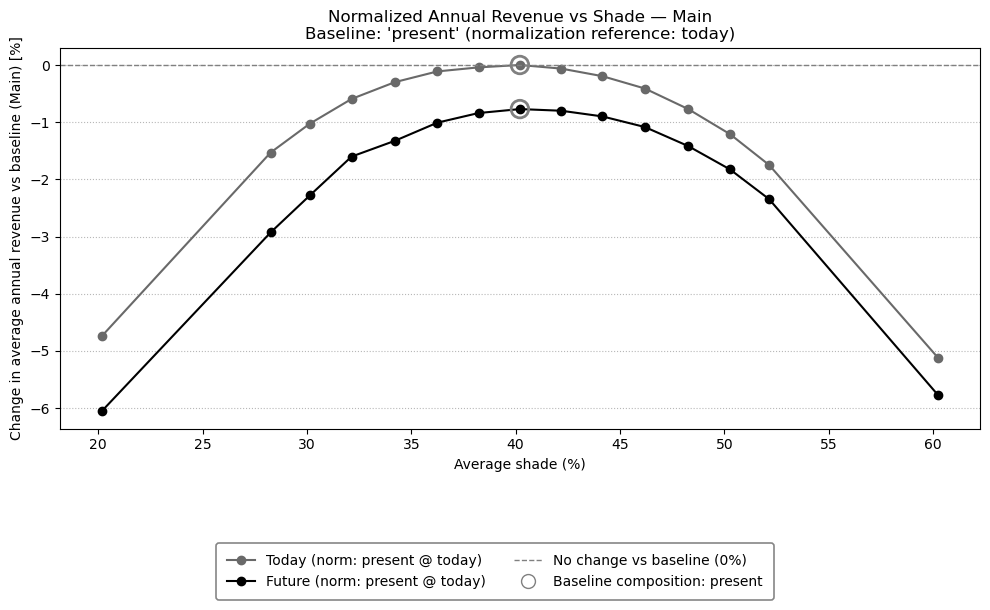

In [46]:
from utils_CB import plot_normalized_annual_revenue

# Remove both 'cacao_to_coffee' and 'coffee_to_cacao' to only focus in the shade to yield trade-off
plot_df = est_values_df[
    (est_values_df["Composition"] != "cacao_to_coffee") &
    (est_values_df["Composition"] != "coffee_to_cacao")
].copy()

fig, ax = plot_normalized_annual_revenue(plot_df, role='Main', baseline_comp='present', show_labels=False, normalize_to='today')

# SAve teh figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_normalized_main_today.png", dpi=300, bbox_inches='tight')



#### 8.3.2 – Future Revenue & Risk Attribution (relative to baseline **c**)

We treat $Y_p(\cdot)$ as the **present, realized (risk-affected) expected revenue**.  
To separate canopy (biophysical) effects from hazard effects, we introduce the **hazard-less potential** $ Y_0(\cdot) $.

##### Modeling basis – Losses due to Hazard

The **observed baseline revenues** $Y_p(x)$ are already *realized outcomes* — they include the effects of present hazards (in the same way that historical agricultural yield data reflect climate variability and losses).  

To separate canopy (biophysical) potential from hazard impacts, we introduce a notional **hazard-less potential** $Y_0(x)$. This is not directly observable, but serves as a bookkeeping device: realized yield is obtained by scaling down $Y_0(x)$ according to hazard-induced losses.  

Let $L_p(x)$ and $L_f(x)$ be the random annual losses at canopy $x$ under **present** and **future** climates, respectively. The **Annual Average Loss (AAL)** is the expected **fraction** of the hazard-less potential:
$$
\mathrm{AAL}_p(x)=\frac{\mathbb{E}[L_p(x)]}{Y_0(x)},\qquad
\mathrm{AAL}_f(x)=\frac{\mathbb{E}[L_f(x)]}{Y_0(x)}.
$$

Realized (risk-affected) expected revenues are therefore:
$$
Y_p(x)=Y_0(x)\,[1-\mathrm{AAL}_p(x)],\qquad
Y_f(x)=Y_0(x)\,[1-\mathrm{AAL}_f(x)].
$$

From the table (which contains $Y_p$ and $\mathrm{AAL}_p$, you can back out the hazard-less potential:
$$
Y_0(x)=\frac{Y_p(x)}{1-\mathrm{AAL}_p(x)}.
$$

*All AAL inputs are fractions (e.g., $5\%\Rightarrow 0.05$ ).*


--- 

##### Notation
- Baseline canopy: $c$. Alternative: $c'$.
- Present raw revenue at canopy $x$: $Y_p(x)$.
- AAL fractions: $\mathrm{AAL}_p(x),\ \mathrm{AAL}_f(x)\in[0,1)$.
- **Retention (future vs present)**:
$$
R(x)=\frac{1-\mathrm{AAL}_f(x)}{1-\mathrm{AAL}_p(x)}.
$$
- **Gain ratio (present canopy effect)**:
$$
g(c',c)=\frac{Y_p(c')}{Y_p(c)}, \qquad \text{so } g(c,c)=1.
$$
- **Risk ratio (relative retention)**:
$$
r(c',c)=\frac{R(c')}{R(c)}.
$$

---

##### Core equations

**Future revenue if you keep vs. switch**
$$
Y_f(c')=Y_p(c')\,R(c')=Y_p(c)\,g(c',c)\,R(c').
$$

**Decision rule (is switching beneficial?)**
$$
\rho=\frac{Y_f(c')}{Y_f(c)} = g(c',c)\,r(c',c).
$$
Beneficial iff $\rho>1$.

---

##### Present-year attribution (using present AALs)

We calculate the risk and gain attributions such that their sum exactly equals the total present change, i.e. $\Delta Y_{\text{present}}(c',c) = \Delta\mathrm{risk}_{\text{present}}(c',c) + \Delta\mathrm{gain}_{\text{present}}(c',c)$.

**Total present change**
$$
\Delta Y_{\text{present}}(c',c)
= Y_p(c') - Y_p(c).
$$

**Risk attribution (present)**
$$
\Delta\mathrm{risk}_{\text{present}}(c',c)
= Y_p(c)\,\Big([1-\mathrm{AAL}_p(c')]-[1-\mathrm{AAL}_p(c)]\Big).
$$

**Gain attribution (present)**
$$
\Delta\mathrm{gain}_{\text{present}}(c',c)
=\Delta Y_{\text{present}}(c',c)-\Delta\mathrm{risk}_{\text{present}}(c',c).
$$

---

##### Risk-first attribution (future)

**Total future change**
$$
\Delta Y_{\text{future}}(c',c)=Y_f(c')-Y_f(c).
$$

**Risk attribution (future)**
$$
\Delta\mathrm{risk}_{\text{future}}(c',c)=Y_p(c)\,\big[R(c')-R(c)\big].
$$

**Gain attribution (future) — simplified**
$$
\Delta\mathrm{gain}_{\text{future}}(c',c)
=\Delta Y_{\text{future}}(c',c)-\Delta\mathrm{risk}_{\text{future}}(c',c).
$$

---

*All AAL inputs must be **fractions** (e.g., $5\%\Rightarrow 0.05$).*


Derive the gain and risk attribution

In [47]:
import numpy as np
import pandas as pd
from utils_CB import derive_gain_risk_from_est

# Derive gain and risk from the estimated values DataFrame
df_gain_risk = derive_gain_risk_from_est(
    est_values_df=est_values_df,
    baseline='present',  # Use 'present' as the baseline composition
    segment='Main',     # Analyze total segment
)
print(tabulate(df_gain_risk, headers='keys', tablefmt='psql'))

+----+-----------------+-----------+--------------+---------------+---------+---------+-------------+-------------+----------+-----------+-----------+-----------------------------+---------------------------------+--------------+-----------------+-----------------+-------------+----------------+----------------+
|    | Composition     | Segment   |   Avg. shade |   Costs (NPV) |      Yp |      Yf |   AALp_frac |   AALf_frac |        R |   g(c,c′) |   r(c,c′) |   ρ_future = Yf/Yf_baseline | Beneficial_vs_future_baseline   |   ΔY_present |   Δrisk_present |   Δgain_present |   ΔY_future |   Δrisk_future |   Δgain_future |
|----+-----------------+-----------+--------------+---------------+---------+---------+-------------+-------------+----------+-----------+-----------+-----------------------------+---------------------------------+--------------+-----------------+-----------------+-------------+----------------+----------------|
|  0 | present         | Main      |      40.2022 |       

📊 Revenue Attribution Plots

The following figures show the **change in annual revenue** (relative to the *present* baseline)  
for different canopy alternatives. The attribution is split into:  

- **Δgain (orange bars):** changes due to canopy–yield function (biophysical gains/losses from shade).  
- **Δrisk (blue bars):** changes due to hazard impact attribution (heat and VPD risk adjustments).  
- **ΔY total (black line):** net effect (sum of Δgain and Δrisk).  

We look at different segments:  
- **Main crop** (coffee/cacao)  
- **Secondary crop** (banana, fruits)  
- **Total** (system-wide)  

---

❓ Reflection Questions
- Do you see cases where **yield–canopy gains (Δgain)** dominate over risk effects?  
  (e.g. does the curve shift upwards with more shade for the main crop?)  
- Conversely, are there scenarios where **risk attribution (Δrisk)** is the main driver of losses or gains?  
- How does this differ between the **Main** and **Secondary** segments?  
- For the **Total system**, which factor seems to dominate the net outcome:  
  yield–shade function or climate risk reduction?  


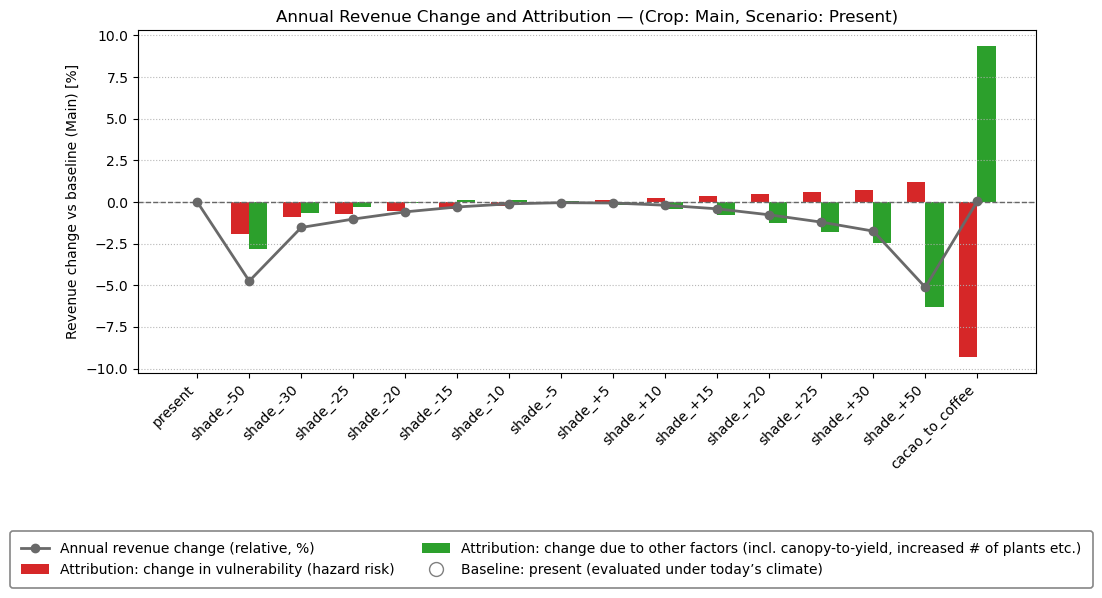

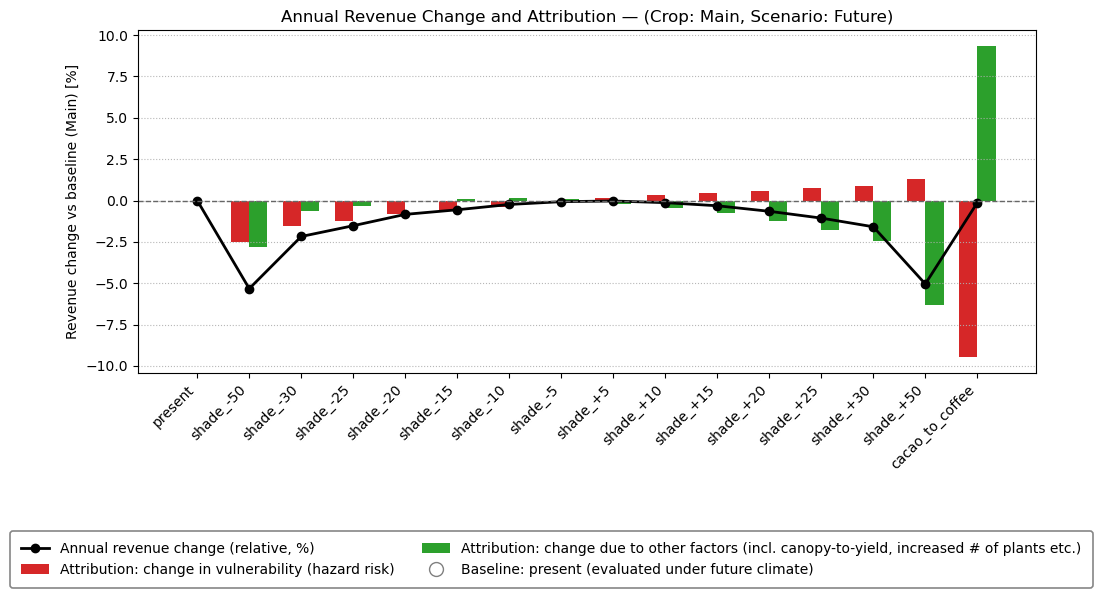

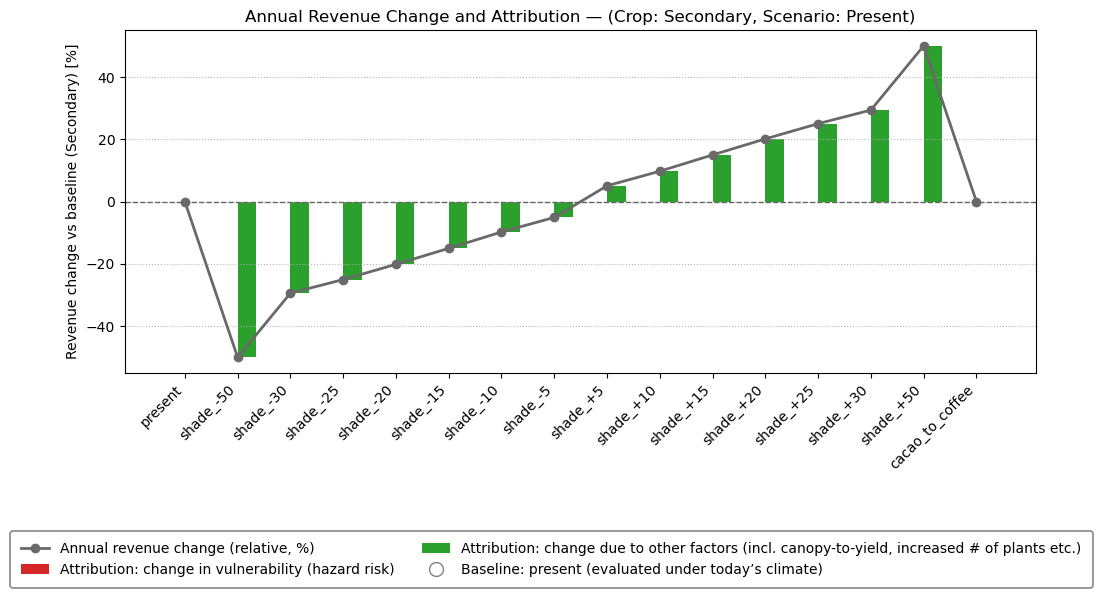

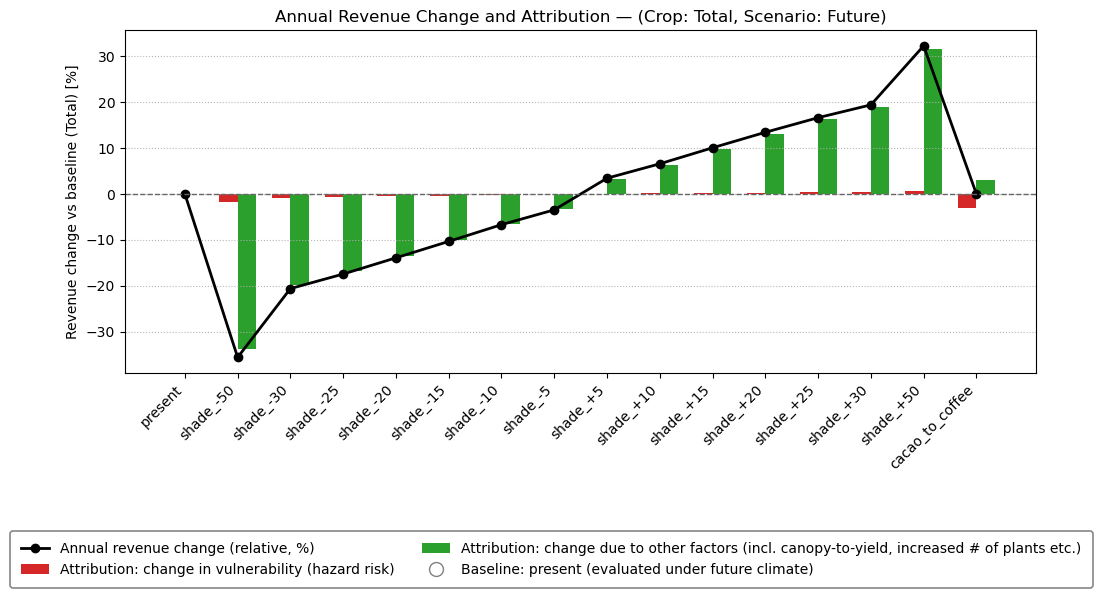

In [48]:
from utils_CB import plot_yield_attribution_grouped

# Show the risk attribution for the change in annual revenue for the 'Main' segment for the 'present' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Main",
                                            view="today",
                                            sort_by=None,
                                            relative=True,
                                            mode="attribution")
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_main_present.png", dpi=300, bbox_inches='tight')

fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Main",
                                            view="future",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_main_future.png", dpi=300, bbox_inches='tight')

# Show the risk attribution for the change in annual revenue for the 'Secondary' segment for the 'future' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Secondary",
                                            view="present",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_secondary_present.png", dpi=300, bbox_inches='tight')

# Show the risk attribution for the change in annual revenue for the 'Total' segment for the 'future' baseline
fig, ax = plot_yield_attribution_grouped(est_values_df,
                                            baseline="present",
                                            segment="Total",
                                            view="future",
                                            sort_by=None,
                                            relative=True)
plt.show()
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/annual_revenue_attribution_total_future.png", dpi=300, bbox_inches='tight')


📊 Exposure vs. Revenue Attribution (Today only)

We can now compare the two:
- **Exposure attribution** (composition of crop value by Role/Species)  
- **Revenue attribution** (annual revenue change vs. baseline, attributed to yield–canopy gains vs. risk adjustments)

⚠️ Note: Revenue attribution is only implemented for the *today* scenario in this workflow.


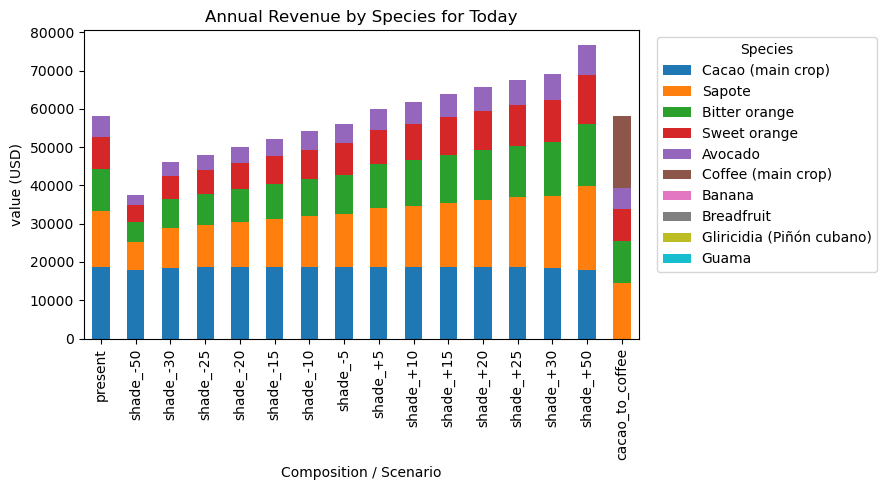

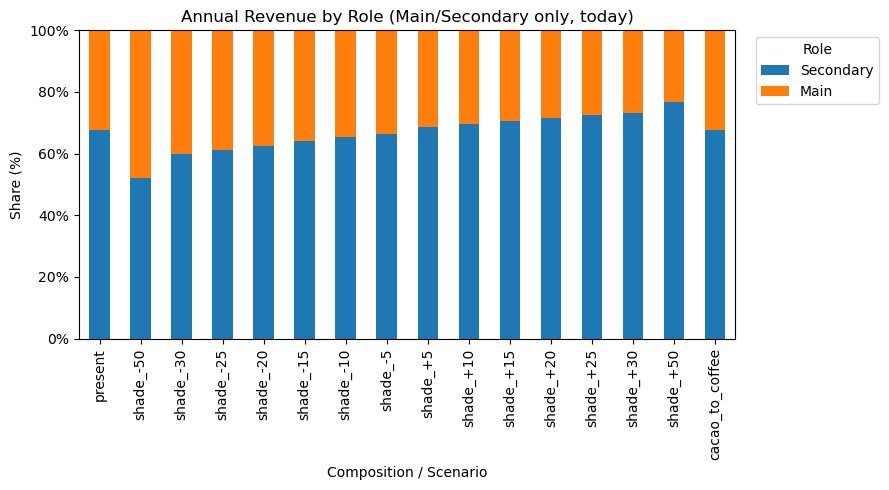

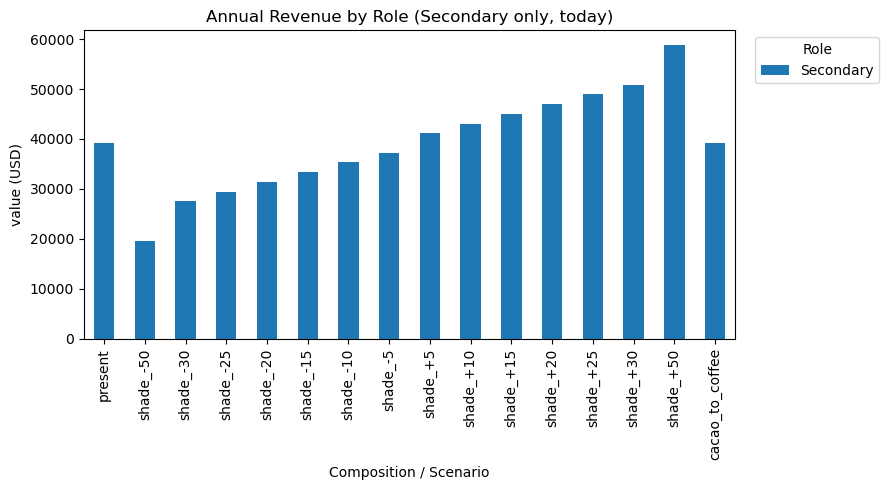

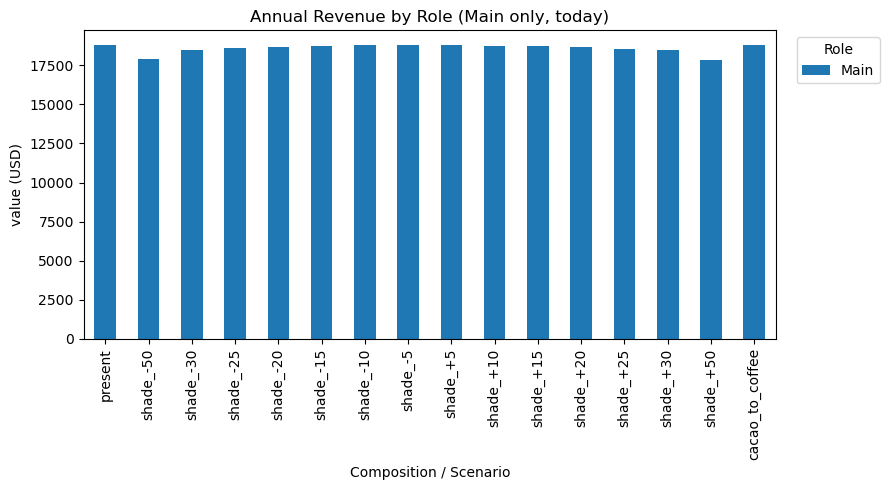

In [49]:
from utils_CB import plot_value_stacked_simple

# 1) Absolute values stacked by Species (all groups)
_, _, fig = plot_value_stacked_simple(exp_dict, group_col='Species', day='today', title='Annual Revenue by Species for Today')
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_species_today.png", dpi=300, bbox_inches='tight')


# 2) Percentage shares by Role, only show Main/Secondary (others -> 'Other')
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Main', 'Secondary'], include_other=True, as_percent=True,
    title='Annual Revenue by Role (Main/Secondary only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_main_secondary_today.png", dpi=300, bbox_inches='tight')

# 3) Only show a chosen subset (drop everything else)
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Secondary'], include_other=False, title='Annual Revenue by Role (Secondary only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_secondary_today.png", dpi=300, bbox_inches='tight')

# 4) Absolute values stacked by Role (all groups)
_, _, fig = plot_value_stacked_simple(
    exp_dict, group_col='Role', day='today',
    subset=['Main'], include_other=False, title='Annual Revenue by Role (Main only, today)',
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/value_stacked_role_main_today.png", dpi=300, bbox_inches='tight')

## 8.4 – Calculate Net Present Value (NPV) and Cost–Benefit Analysis

In this final step we combine the **cost streams** (planting + maintenance) with the **revenue projections** (canopy-adjusted yields × prices, including hazard-adjusted risk losses). Both costs and revenues are discounted to present value using the **DiscountRate** object.  

This allows us to calculate:  
- **NPV of costs** (per composition)  
- **NPV of revenues** (per composition)  
- **Net Benefit = Revenues – Costs**  

We then plot the comparative results across canopy alternatives to identify which scenarios are **economically advantageous** when accounting for both production trade-offs and climate risk reduction benefits.


Estimate the net present value of the revenue streams

In [50]:
import numpy as np
import pandas as pd


inflation_rate = 0.02  # 2% annual inflation
npv_rows = []

# Calculate NPV for each role in each composition
for _, row in est_values_df.iterrows():
    role_data = {}
    role_data["Composition"] = row["Composition"]

    for role in ["Total", "Main", "Secondary"]:
        rev_today = row.get(f"Avg. Revenue – {role} (today)", 0)
        rev_future = row.get(f"Avg. Revenue – {role} (future)", 0)

        if pd.isna(rev_today) or pd.isna(rev_future) or rev_today == 0:
            role_data[f"Revenue (NPV) – {role}"] = 0
            continue

        # Linear interpolation between today and future over 'years'
        years = FUTURE_YEAR - PRESENT_YEAR + 1
        yearly_revenues = np.linspace(rev_today, rev_future, years)

        # Apply inflation rate (or other growth parameter)
        yearly_revenues = yearly_revenues * (1 + inflation_rate) ** np.arange(1, years + 1)

        # Discount to get NPV
        npv = disc_rate.net_present_value(PRESENT_YEAR, FUTURE_YEAR, yearly_revenues)
        role_data[f"Revenue (NPV) – {role}"] = npv

    npv_rows.append(role_data)

df_npv = pd.DataFrame(npv_rows)
print(tabulate(df_npv, headers='keys', tablefmt='psql'))

+----+-----------------+-------------------------+------------------------+-----------------------------+
|    | Composition     |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |
|----+-----------------+-------------------------+------------------------+-----------------------------|
|  0 | present         |             1.98904e+06 |                 642963 |                 1.34602e+06 |
|  1 | shade_-50       |             1.28251e+06 |                 610418 |            671981           |
|  2 | shade_-30       |             1.58081e+06 |                 630876 |            949827           |
|  3 | shade_-25       |             1.64342e+06 |                 634632 |                 1.00869e+06 |
|  4 | shade_-20       |             1.713e+06   |                 638296 |                 1.07463e+06 |
|  5 | shade_-15       |             1.78414e+06 |                 640130 |                 1.14394e+06 |
|  6 | shade_-10       |             1.85634e+

Calculate the net and the benefit of comparing the present 

In [51]:
# Define the baseline composition for NPV calculations
baseline = "present"

# 1) Keep the role NPVs in your metrics table
df_cb_metrics = est_values_df.merge(df_npv, on="Composition", how="left")

df_cb_metrics = df_cb_metrics[[
    "Composition",
    "Avg. shade",
    "Costs (NPV)",
    "Revenue (NPV) – Total",
    "Revenue (NPV) – Main",
    "Revenue (NPV) – Secondary",
    "Avg. Revenue – Total (today)",
    "Avg. Revenue – Total (future)",
    "Avg. Revenue - Bad Year – Total (today)",
    "Avg. Revenue - Bad Year – Total (future)",
]]

# 2) Net, Benefit, BCR (Total)
df_cb_metrics["Net (NPV)"] = df_cb_metrics["Revenue (NPV) – Total"] - df_cb_metrics["Costs (NPV)"]

baseline_row = df_cb_metrics.loc[df_cb_metrics['Composition'] == baseline].iloc[0]
baseline_net   = baseline_row["Net (NPV)"]
baseline_main  = baseline_row["Revenue (NPV) – Main"]
baseline_sec   = baseline_row["Revenue (NPV) – Secondary"]
baseline_costs = baseline_row["Costs (NPV)"]

# Total benefit and BCR
df_cb_metrics['Benefit'] = df_cb_metrics['Net (NPV)'] - baseline_net
df_cb_metrics['BCR'] = df_cb_metrics['Benefit'] / df_cb_metrics['Costs (NPV)']

# 3) Role-specific benefits and BCRs
df_cb_metrics["Benefit (Main)"]      = df_cb_metrics["Revenue (NPV) – Main"]      - baseline_main
df_cb_metrics["Benefit (Secondary)"] = df_cb_metrics["Revenue (NPV) – Secondary"] - baseline_sec

df_cb_metrics["BCR (Main)"]      = df_cb_metrics["Benefit (Main)"]      / df_cb_metrics["Costs (NPV)"]
df_cb_metrics["BCR (Secondary)"] = df_cb_metrics["Benefit (Secondary)"] / df_cb_metrics["Costs (NPV)"]

# 4) Δ vs baseline components for the attribution plot
df_cb_metrics["ΔRev Main (NPV)"]      = df_cb_metrics["Revenue (NPV) – Main"]      - baseline_main
df_cb_metrics["ΔRev Secondary (NPV)"] = df_cb_metrics["Revenue (NPV) – Secondary"] - baseline_sec
df_cb_metrics["ΔCost (NPV)"]          = df_cb_metrics["Costs (NPV)"]               - baseline_costs

# Consistency check
df_cb_metrics["Benefit_check"] = (
    df_cb_metrics["ΔRev Main (NPV)"] + df_cb_metrics["ΔRev Secondary (NPV)"] - df_cb_metrics["ΔCost (NPV)"]
)

# Print the final metrics DataFrame
print(tabulate(df_cb_metrics, headers='keys', tablefmt='psql'))


+----+-----------------+--------------+---------------+-------------------------+------------------------+-----------------------------+--------------------------------+---------------------------------+-------------------------------------------+--------------------------------------------+-------------+-------------+--------------+------------------+-----------------------+--------------+-------------------+-------------------+------------------------+---------------+-----------------+
|    | Composition     |   Avg. shade |   Costs (NPV) |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |   Avg. Revenue – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue - Bad Year – Total (future) |   Net (NPV) |     Benefit |          BCR |   Benefit (Main) |   Benefit (Secondary) |   BCR (Main) |   BCR (Secondary) |   ΔRev Main (NPV) |   ΔRev Secondary (NPV) |   ΔCost (NPV) |   Benefit_check |
|----+--------

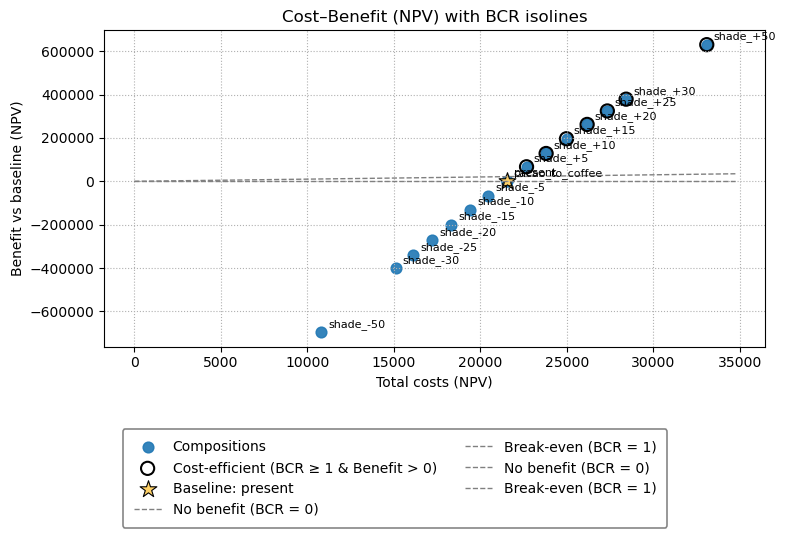

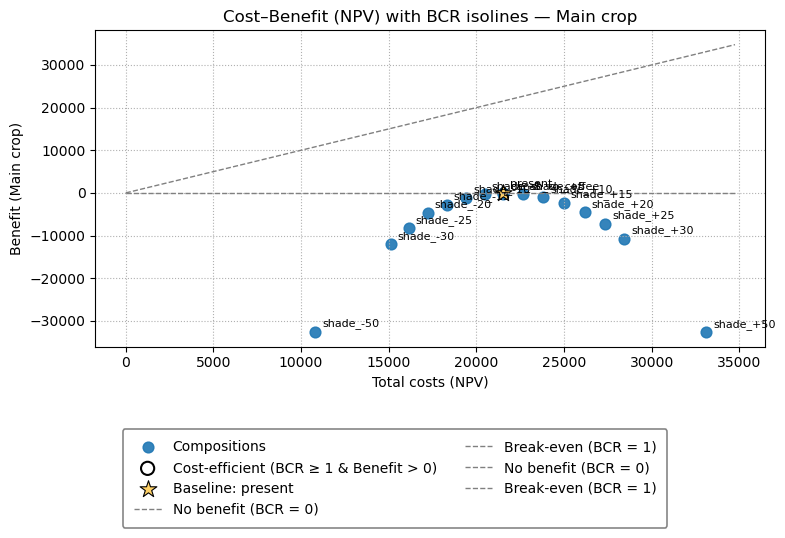

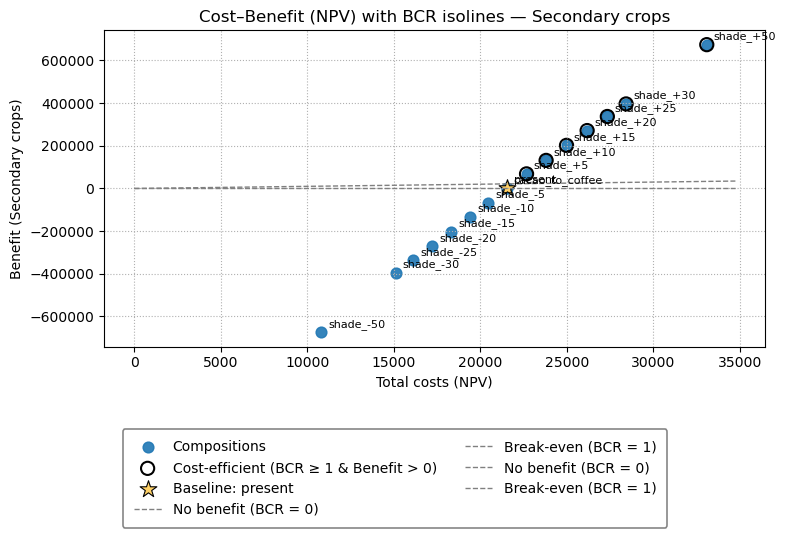

In [52]:
from utils_CB import plot_cost_vs_benefit

# Total (default)
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="total")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_total.png", dpi=300, bbox_inches='tight')

# Main crop
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="main")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_main.png", dpi=300, bbox_inches='tight')

# Secondary crops
fig, ax = plot_cost_vs_benefit(df_cb_metrics, role="secondary")
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cost_vs_benefit_secondary.png", dpi=300, bbox_inches='tight')


**Plot Cost–Benefit Attribution by Role**

This visualization shows the **attribution of benefits and costs** across canopy alternatives,  
relative to the chosen baseline (default = *present*).  

- **ΔBenefit total (NPV)** — hatched black bar  
  - Net benefit relative to baseline = (ΔRev Main + ΔRev Secondary – ΔCost).  

- **ΔRev Main (NPV)** — blue bar  
  - Change in discounted revenue from the **main crop**.  

- **ΔRev Secondary (NPV)** — orange bar  
  - Change in discounted revenue from **secondary crops**.  

- **ΔCost (NPV)** — red bar  
  - Additional (or reduced) discounted costs of planting + maintenance.  

- **BCR (Total)** — purple line (right axis)  
  - Benefit–Cost Ratio, i.e. total discounted benefits divided by discounted costs.  
  - A dashed line at **BCR = 1** indicates the threshold where benefits equal costs.  

---

### Interpretation
This plot lets us answer:  
- Which role (**main vs. secondary**) drives the net benefits under each canopy alternative?  
- Do higher canopy adjustments reduce revenues from the main crop but increase those from secondary crops?  
- Which scenarios cross the **BCR > 1** threshold, making them economically justifiable?  
- How do **cost increases** compare against the gains in revenues and risk reduction?  


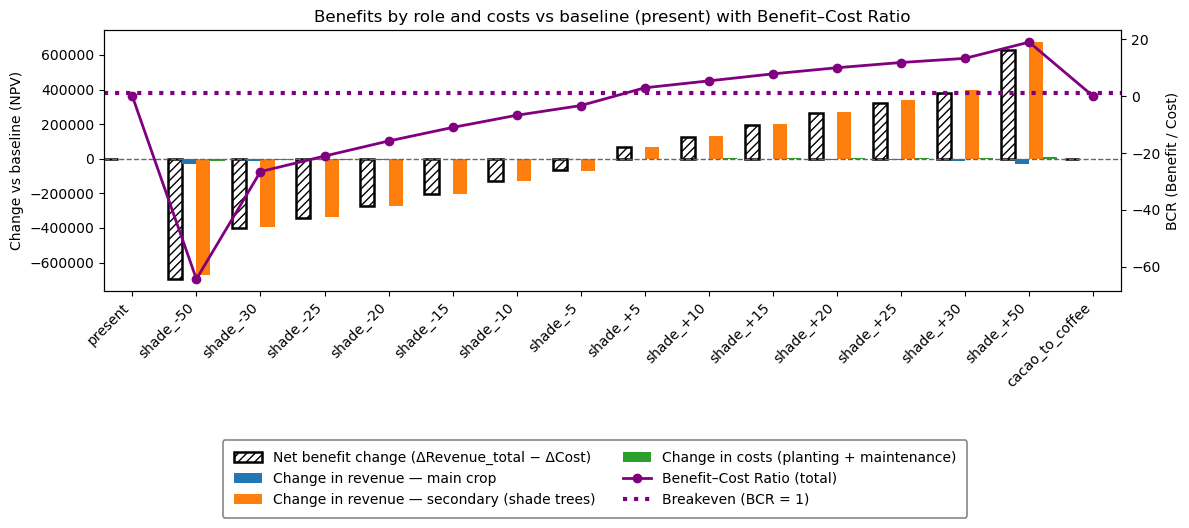

In [53]:
from utils_CB import plot_cb_roles_with_bcr

fig, ax, ax2 = plot_cb_roles_with_bcr(
    df_cb_metrics=df_cb_metrics,
    df_npv=df_npv,            # provide if role NPVs aren't already merged
    baseline="present",
    sort_by=None,
    
)
# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/cb_roles_with_bcr_present.png", dpi=300, bbox_inches='tight')


## *8.5 – Extra: Add biodiversity as a metric*

Is found in *Balancing Act: Meta-analysis of ecological and economic outcomes in Latin American coffee agroforestry systems.* Master’s Thesis. **Contreras Fleury, M. (2025).** 

In [54]:
df_cb_metrics

Composition  Avg. shade  Costs (NPV)  Revenue (NPV) – Total  \
0           present   40.202153      21530.6           1.989037e+06   
1         shade_-50   20.161111      10805.6           1.282514e+06   
2         shade_-30   28.259583      15128.1           1.580810e+06   
3         shade_-25   30.135764      16134.3           1.643420e+06   
4         shade_-20   32.137500      17217.2           1.713003e+06   
5         shade_-15   34.211528      18322.2           1.784144e+06   
6         shade_-10   36.246528      19415.5           1.856344e+06   
7          shade_-5   38.222083      20465.9           1.920260e+06   
8          shade_+5   42.182222      22679.2           2.057160e+06   
9         shade_+10   44.157778      23811.2           2.119542e+06   
10        shade_+15   46.192778      24990.6           2.188793e+06   
11        shade_+20   48.266806      26182.6           2.255871e+06   
12        shade_+25   50.268542      27350.2           2.319084e+06   
13        shade_+30   52.144722      28434.6           2.374530e+06   
14        shade_+50   60.243194      33097.4           2.630390e+06   
15  cacao_to_coffee   40.202153      21530.6           1.988935e+06   

    Revenue (NPV) – Main  Revenue (NPV) – Secondary  \
0          642963.458584               1.346023e+06   
1          610418.252026               6.719810e+05   
2          630875.760711               9.498266e+05   
3          634632.144223               1.008693e+06   
4          638295.582477               1.074634e+06   
5          640129.750343               1.143941e+06   
6          641797.566192               1.214484e+06   
7          642597.206748               1.277609e+06   
8          642676.106983               1.414437e+06   
9          641936.837632               1.477561e+06   
10         640647.616407               1.548105e+06   
11         638421.993893               1.617412e+06   
12         635696.918561               1.683353e+06   
13         632279.072557               1.742219e+06   
14         610298.970804               2.020064e+06   
15         642630.651301               1.346023e+06   

    Avg. Revenue – Total (today)  Avg. Revenue – Total (future)  \
0                   57992.000000                   57849.762668   
1                   37473.703483                   37233.261765   
2                   46168.156654                   45911.218312   
3                   47977.007887                   47746.047511   
4                   49978.392578                   49792.747851   
5                   52051.610247                   51862.599561   
6                   54140.872810                   53975.710820   
7                   55992.133401                   55844.935553   
8                   59972.167965                   59836.098352   
9                   61785.229856                   61655.241396   
10                  63798.592102                   63674.127656   
11                  65749.111675                   65629.404086   
12                  67586.634681                   67472.507697   
13                  69199.168244                   69088.496264   
14                  76654.769541                   76533.577564   
15                  58000.200000                   57837.480055   

    Avg. Revenue - Bad Year – Total (today)  \
0                              57357.313313   
1                              36672.947313   
2                              45386.458025   
3                              47217.012794   
4                              49241.073050   
5                              51340.054613   
6                              53452.954864   
7                              55329.846327   
8                              59388.770765   
9                              61220.276279   
10                             63259.621260   
11                             65286.031932   
12                             67144.929542   
13                             68774.925061   
14                 

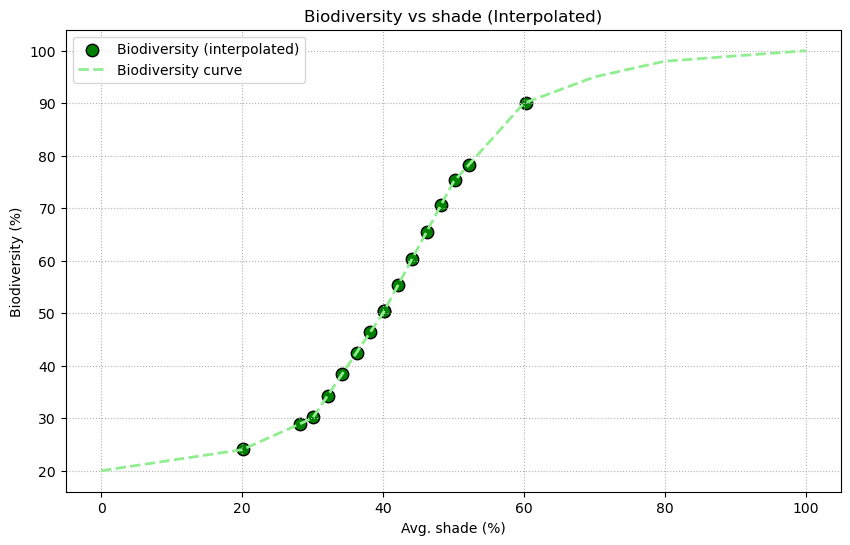

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your two data sources
shade_biodiversity_df = pd.read_csv("Data/shade_biodiversity.csv")

# Interpolation function
def interpolate_biodiversity(canopy_value, shade_biodiversity_df):
    return np.interp(
        canopy_value,
        shade_biodiversity_df["Shade (%)"],
        shade_biodiversity_df["Biodiversity (%)"]
    )

# Apply smooth mapping
df_cb_metrics["Biodiversity (%)"] = df_cb_metrics["Avg. shade"].apply(
    lambda v: interpolate_biodiversity(v, shade_biodiversity_df)
)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10,6))

# Scatter for actual data
ax.scatter(df_cb_metrics["Avg. shade"], df_cb_metrics["Biodiversity (%)"],
           s=80, color="green", edgecolor="black", label="Biodiversity (interpolated)")

# Optionally, plot smooth reference biodiversity curve too
ax.plot(shade_biodiversity_df["Shade (%)"], shade_biodiversity_df["Biodiversity (%)"],
        color="lightgreen", linewidth=2, linestyle="--", label="Biodiversity curve")

plt.title("Biodiversity vs shade (Interpolated)")
plt.xlabel("Avg. shade (%)")
plt.ylabel("Biodiversity (%)")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()

# Save the figure in the results folder OUTPUT_DIR
fig.savefig(f"{OUTPUT_DIR}/biodiversity_vs_canopy.png", dpi=300, bbox_inches='tight')


## 8.6 – Store the results as an excel file

In [56]:
print(tabulate(df_cb_metrics, headers='keys', tablefmt='psql'))

+----+-----------------+--------------+---------------+-------------------------+------------------------+-----------------------------+--------------------------------+---------------------------------+-------------------------------------------+--------------------------------------------+-------------+-------------+--------------+------------------+-----------------------+--------------+-------------------+-------------------+------------------------+---------------+-----------------+--------------------+
|    | Composition     |   Avg. shade |   Costs (NPV) |   Revenue (NPV) – Total |   Revenue (NPV) – Main |   Revenue (NPV) – Secondary |   Avg. Revenue – Total (today) |   Avg. Revenue – Total (future) |   Avg. Revenue - Bad Year – Total (today) |   Avg. Revenue - Bad Year – Total (future) |   Net (NPV) |     Benefit |          BCR |   Benefit (Main) |   Benefit (Secondary) |   BCR (Main) |   BCR (Secondary) |   ΔRev Main (NPV) |   ΔRev Secondary (NPV) |   ΔCost (NPV) |   Benefit_c

In [57]:
import pandas as pd

output_file = OUTPUT_DIR / file_name.replace(".xlsx", "_cb_metrics.xlsx")

# Round numeric values
df_fmt = df_cb_metrics.copy()
numeric_cols = df_fmt.select_dtypes(include="number").columns
df_fmt[numeric_cols] = df_fmt[numeric_cols].round(2)

with pd.ExcelWriter(output_file, engine="xlsxwriter") as writer:
    df_fmt.to_excel(writer, index=False, sheet_name="CB Metrics")
    workbook  = writer.book
    worksheet = writer.sheets["CB Metrics"]

    # Formats
    money_fmt   = workbook.add_format({'num_format': '#,##0'})
    dec_fmt     = workbook.add_format({'num_format': '0.00'})
    header_fmt  = workbook.add_format({
        'bold': True, 'text_wrap': True, 'valign': 'top',
        'fg_color': '#D7E4BC', 'border': 1
    })

    # Apply header formatting
    for col_num, value in enumerate(df_fmt.columns.values):
        worksheet.write(0, col_num, value, header_fmt)

    # Define column widths and formats separately
    col_settings = {
        "Composition": (20, None),
        "Avg. shade": (20, dec_fmt),
        "Costs (NPV)": (15, money_fmt),
        "Revenue (NPV) – Total": (20, money_fmt),
        "Revenue (NPV) – Main": (20, money_fmt),
        "Revenue (NPV) – Secondary": (22, money_fmt),
        "Avg. Revenue – Total (today)": (25, money_fmt),
        "Avg. Revenue – Total (future)": (25, money_fmt),
        "Avg. Revenue - Bad Year – Total (today)": (30, money_fmt),
        "Avg. Revenue - Bad Year – Total (future)": (30, money_fmt),
        "Net (NPV)": (15, money_fmt),
        "Benefit": (15, money_fmt),
        "BCR": (10, dec_fmt),
        "ΔRev Main (NPV)": (18, money_fmt),
        "ΔRev Secondary (NPV)": (22, money_fmt),
        "ΔCost (NPV)": (15, money_fmt),
        "Benefit_check": (18, money_fmt),
        "Biodiversity (%)": (15, dec_fmt),
    }

    # Apply widths and formats
    for i, col in enumerate(df_fmt.columns):
        width, fmt = col_settings.get(col, (max(12, len(col) + 2), None))
        worksheet.set_column(i, i, width, fmt)

    est_values_df.to_excel(writer, index=False, sheet_name="Estimated Values")
    est_values_sheet = writer.sheets["Estimated Values"]

    # Define column widths and formats for est_values_df
    est_col_settings = {
        "Composition": (20, None),
        "Avg. shade": (20, dec_fmt),
        "Costs (NPV)": (15, money_fmt),
        "Avg. Revenue – Total (today)": (25, money_fmt),
        "AAL % – Total (today)": (15, dec_fmt),
        "AAL % – Total (future)": (15, dec_fmt),
        "Avg. Revenue - Bad Year – Total (today)": (30, money_fmt),
        "Avg. Revenue – Total (future)": (25, money_fmt),
        "Avg. Revenue - Bad Year – Total (future)": (30, money_fmt),
        "Avg. Revenue – Main (today)": (25, money_fmt),
        "AAL % – Main (today)": (15, dec_fmt),
        "AAL % – Main (future)": (15, dec_fmt),
        "Avg. Revenue – Main (future)": (25, money_fmt),
        "Avg. Revenue – Secondary (today)": (25, money_fmt),
        "AAL % – Secondary (today)": (15, dec_fmt),
        "AAL % – Secondary (future)": (15, dec_fmt),
        "Avg. Revenue – Secondary (future)": (25, money_fmt),
    }

    # Apply widths and formats for est_values_df
    for i, col in enumerate(est_values_df.columns):
        width, fmt = est_col_settings.get(col, (max(12, len(col) + 2), None))
        est_values_sheet.set_column(i, i, width, fmt)